<a name="Datasets_Description"></a>
## Datasets Description

Molecular Taxonomy of Breast Cancer International Consortium (METABRIC) Dataset
The dataset used is the Molecular Taxonomy of Breast Cancer International Consortium (METABRIC) database, which is a Canada-UK Project which contains targeted sequencing data of 1,980 primary breast cancer samples. 
This is a huge dataset with 1904 rows and 693 columns which among it, 31 columns are the clinical attributes and the rest are the genetic attributes.
Source: https://www.cbioportal.org/


<a name="Data_Import_and_Cleaning"></a>
## Data Import & Cleaning

In [52]:
#Basic libraries
import numpy as np
import pandas as pd
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yellowbrick as yb
from matplotlib.colors import ListedColormap
from yellowbrick.classifier import ROCAUC
from matplotlib_venn import venn3
import matplotlib.patches as mpatches

# Statistics, EDA, metrics libraries
from scipy.stats import normaltest, skew
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import boxcox, inv_boxcox

# Modeling libraries
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict,  KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from scipy.stats import zscore
from itertools import combinations
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import IsolationForest
import kmapper as km
from sklearn.cluster import KMeans


from IPython.display import set_matplotlib_formats 
plt.style.use('ggplot')
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")


# Pallets used for visualizations
color= "Spectral"
color_plt = ListedColormap(sns.color_palette(color).as_hex())
color_hist = 'teal'
two_colors = [ sns.color_palette(color)[0], sns.color_palette(color)[5]]
three_colors = [ sns.color_palette(color)[5],sns.color_palette(color)[2], sns.color_palette(color)[0]]

In [53]:
df = pd.read_csv('METABRIC_RNA_Mutation.csv', delimiter=',')
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1904 rows and 693 columns


In [54]:
df.head()

patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0                76             MASTECTOMY  Breast Cancer   
1           2                43      BREAST CONSERVING  Breast Cancer   
2           5                49             MASTECTOMY  Breast Cancer   
3           6                48             MASTECTOMY  Breast Cancer   
4           8                77             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4  Breast Mixed Ductal and Lobular Carcinoma        High             1   

  pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc  ... mtap_mut  \
0                 claudin-low       1                   Positve  ...        0   
1                        LumA       1                   Positve  ...        0   
2                        LumB       1                   Positve  ...        0   
3                        LumB       1                   Positve  ...        0   
4                        LumB       1                   Positve  ...        0   

   ppp2cb_mut smarcd1_mut nras_mut ndfip1_mut  hras_mut prps2_mut smarcb1_mut  \
0           0           0        0          0         0         0           0   
1           0           0        0          0         0         0           0   
2           0           0        0          0         0         0           0   
3           0           0        0          0         0         0           0   
4           0           0        0          0         0         0           0   

  stmn2_mut  siah1_mut  
0         0          0  
1         0          0  
2         0          0  
3         0          0  
4         0          0  

[5 rows x 693 columns]

In [55]:
#Finding missing data and the percentage of it in each column
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total_NaN', 'Percent_Nan'])
missing_data.head(14)

Total_NaN  Percent_Nan
tumor_stage                           501     0.263130
3-gene_classifier_subtype             204     0.107143
primary_tumor_laterality              106     0.055672
neoplasm_histologic_grade              72     0.037815
cellularity                            54     0.028361
mutation_count                         45     0.023634
er_status_measured_by_ihc              30     0.015756
type_of_breast_surgery                 22     0.011555
tumor_size                             20     0.010504
cancer_type_detailed                   15     0.007878
oncotree_code                          15     0.007878
tumor_other_histologic_subtype         15     0.007878
death_from_cancer                       1     0.000525
ar                                      0     0.000000

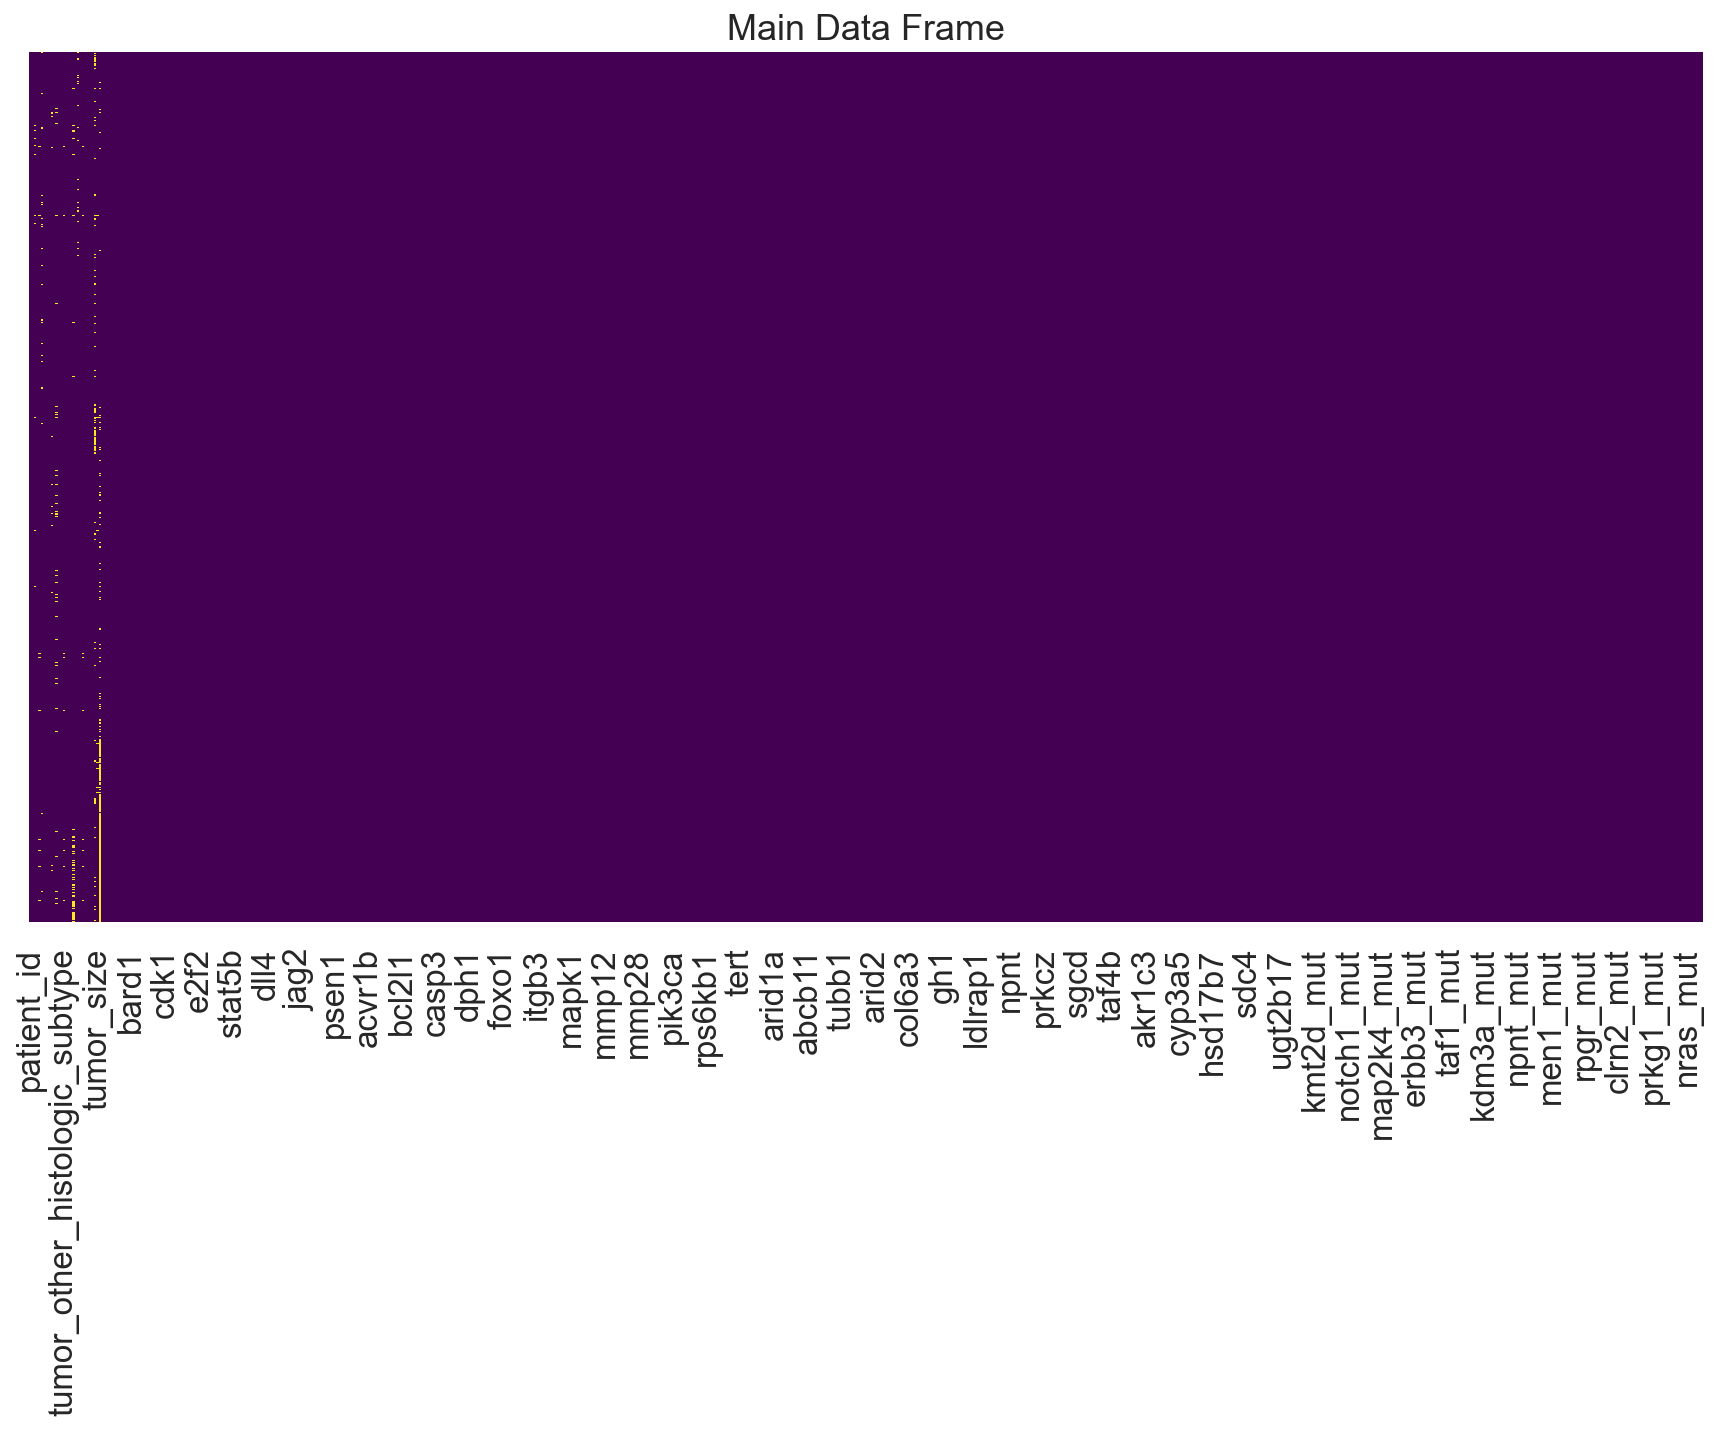

In [56]:
# Visualization of missing data
fig, ax = plt.subplots( figsize = (15, 8))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
ax.set_title('Main Data Frame')
plt.show();

The genetic data in the dataframe is complete with no missing data. However, the clinical data has some categorical clinical features that had up to 26% missing data (tumor_stage column has 26% missing data, while 3-gene_classifier_subtype has 10.7% missing data, and primary_tumor_laterality contains 3.7% missing data). There are 9 features that contains around 3 -0.001% missing data, and the rest of the features are complete. 

<a name="Exploratory_Data_Analysis"></a>
## Exploratory Data Analysis  and Data Visualization


<a name="clinical"></a>
### a) Relationship between clinical attributes and outcomes

In [57]:
# create a new dataframe for clinical attributes only
clinical_features_to_drop = df.columns[31:] # non clinical attributes
clinical_df = df.drop(clinical_features_to_drop, axis=1)
clinical_df.head()

patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0                76             MASTECTOMY  Breast Cancer   
1           2                43      BREAST CONSERVING  Breast Cancer   
2           5                49             MASTECTOMY  Breast Cancer   
3           6                48             MASTECTOMY  Breast Cancer   
4           8                77             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4  Breast Mixed Ductal and Lobular Carcinoma        High             1   

  pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc  ...  \
0                 claudin-low       1                   Positve  ...   
1                        LumA       1                   Positve  ...   
2                        LumB       1                   Positve  ...   
3                        LumB       1                   Positve  ...   
4                        LumB       1                   Positve  ...   

  nottingham_prognostic_index  oncotree_code overall_survival_months  \
0                       6.044            IDC              140.500000   
1                       4.020            IDC               84.633333   
2                       4.030            IDC              163.700000   
3                       4.050           MDLC              164.933333   
4                       6.080           MDLC               41.366667   

  overall_survival pr_status  radio_therapy 3-gene_classifier_subtype  \
0                1  Negative              1                 ER-/HER2-   
1                1  Positive              1     ER+/HER2- High Prolif   
2                0  Positive              0                       NaN   
3                1  Positive              1                       NaN   
4                0  Positive              1     ER+/HER2- High Prolif   

  tumor_size tumor_stage  death_from_cancer  
0       22.0         2.0             Living  
1       10.0         1.0             Living  
2       15.0         2.0    Died of Disease  
3       25.0         2.0             Living  
4       40.0         2.0    Died of Disease  

[5 rows x 31 columns]

In [58]:
clinical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      1904 non-null   int64  
 1   age_at_diagnosis                1904 non-null   int64  
 2   type_of_breast_surgery          1882 non-null   object 
 3   cancer_type                     1904 non-null   object 
 4   cancer_type_detailed            1889 non-null   object 
 5   cellularity                     1850 non-null   object 
 6   chemotherapy                    1904 non-null   int64  
 7   pam50_+_claudin-low_subtype     1904 non-null   object 
 8   cohort                          1904 non-null   int64  
 9   er_status_measured_by_ihc       1874 non-null   object 
 10  er_status                       1904 non-null   object 
 11  neoplasm_histologic_grade       1832 non-null   float64
 12  her2_status_measured_by_snp6    19

- #### The Distribution of Clinical Columns in the Dataframe

In [59]:
# a function that takes a dataframe and transforms it into a standard form after dropping nun_numirical columns
def to_standard (df):
    
    num_df = df[df.select_dtypes(include = np.number).columns.tolist()]
    
    ss = StandardScaler()
    std = ss.fit_transform(num_df)
    
    std_df = pd.DataFrame(std, index = num_df.index, columns = num_df.columns)
    return std_df

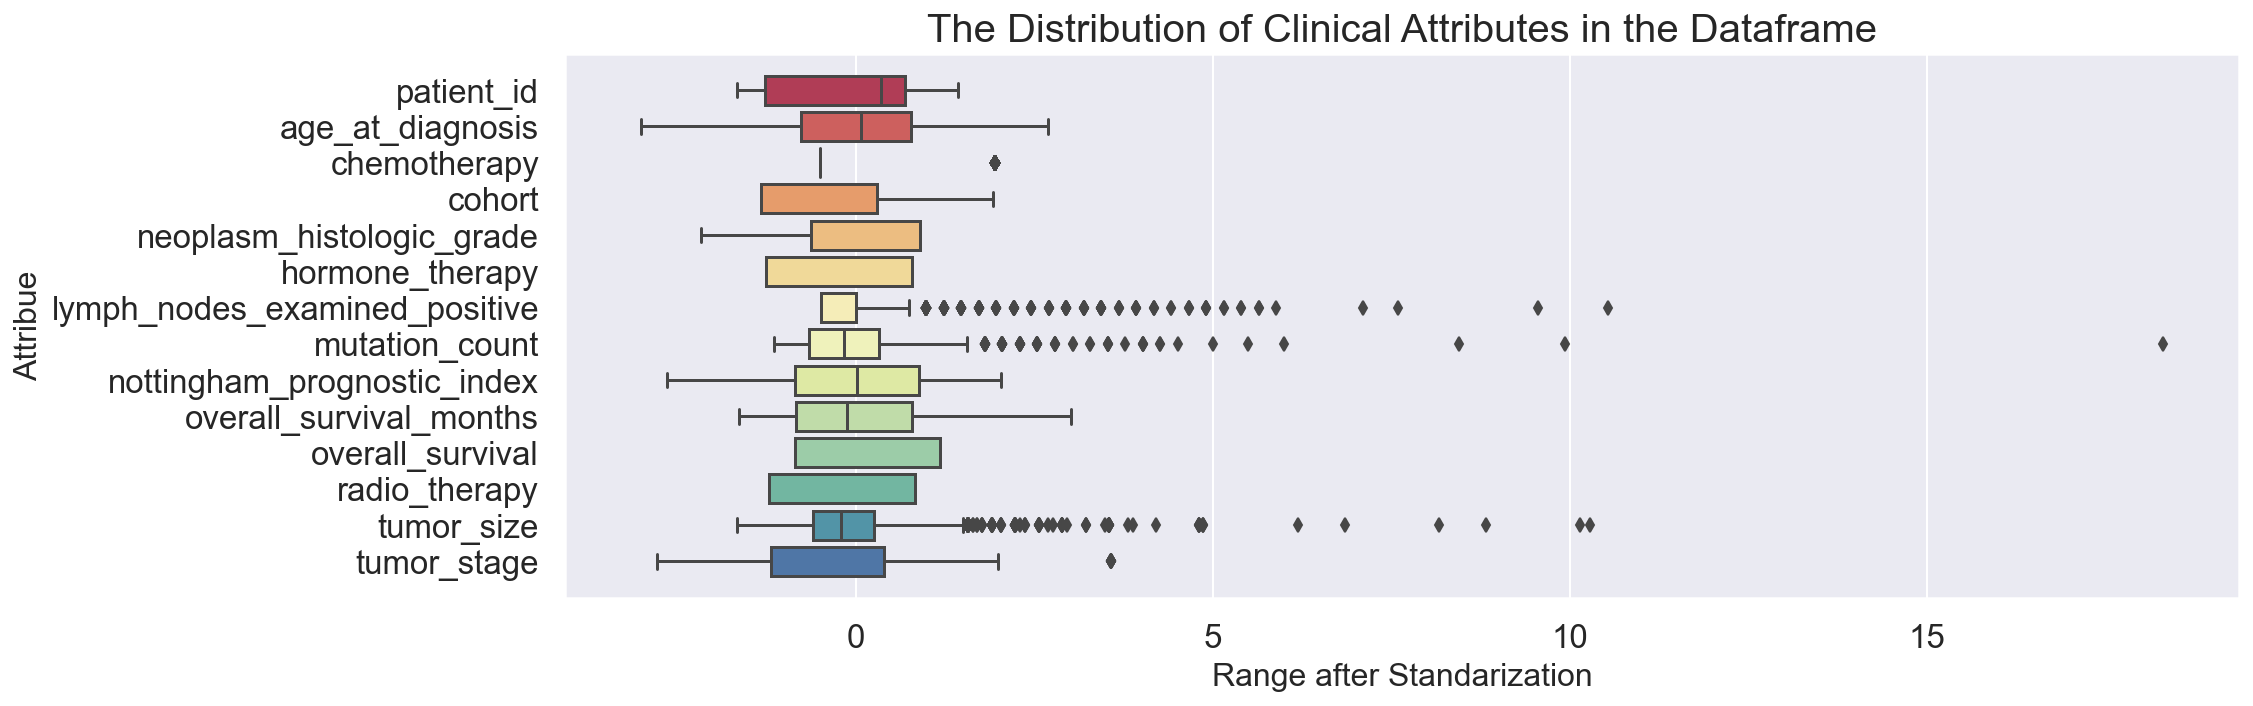

In [60]:
ax, fig = plt.subplots(1, 1, figsize = (15, 5))
plt.title('The Distribution of Clinical Attributes in the Dataframe', fontsize = 20) #Change please

sns.boxplot(y = "variable", x = "value", data = pd.melt(to_standard(clinical_df)), palette = 'Spectral')
plt.xlabel('Range after Standarization', size = 16)
plt.ylabel('Attribue', size = 16)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

For the distribution of all numerical data, some of them are normally distributed (like tumor_stage, and age_at_diagnosis), but  most of the features are right skewed with a lot of outliers (lymph_nodes_examined_positive, mutation_count, and tumor_size).   We decided to keep the outliers, as they are very important in healthcare data. 

- #### The Distribution of the Two Target Classes in Numerical Clinical Columns in the Dataframe

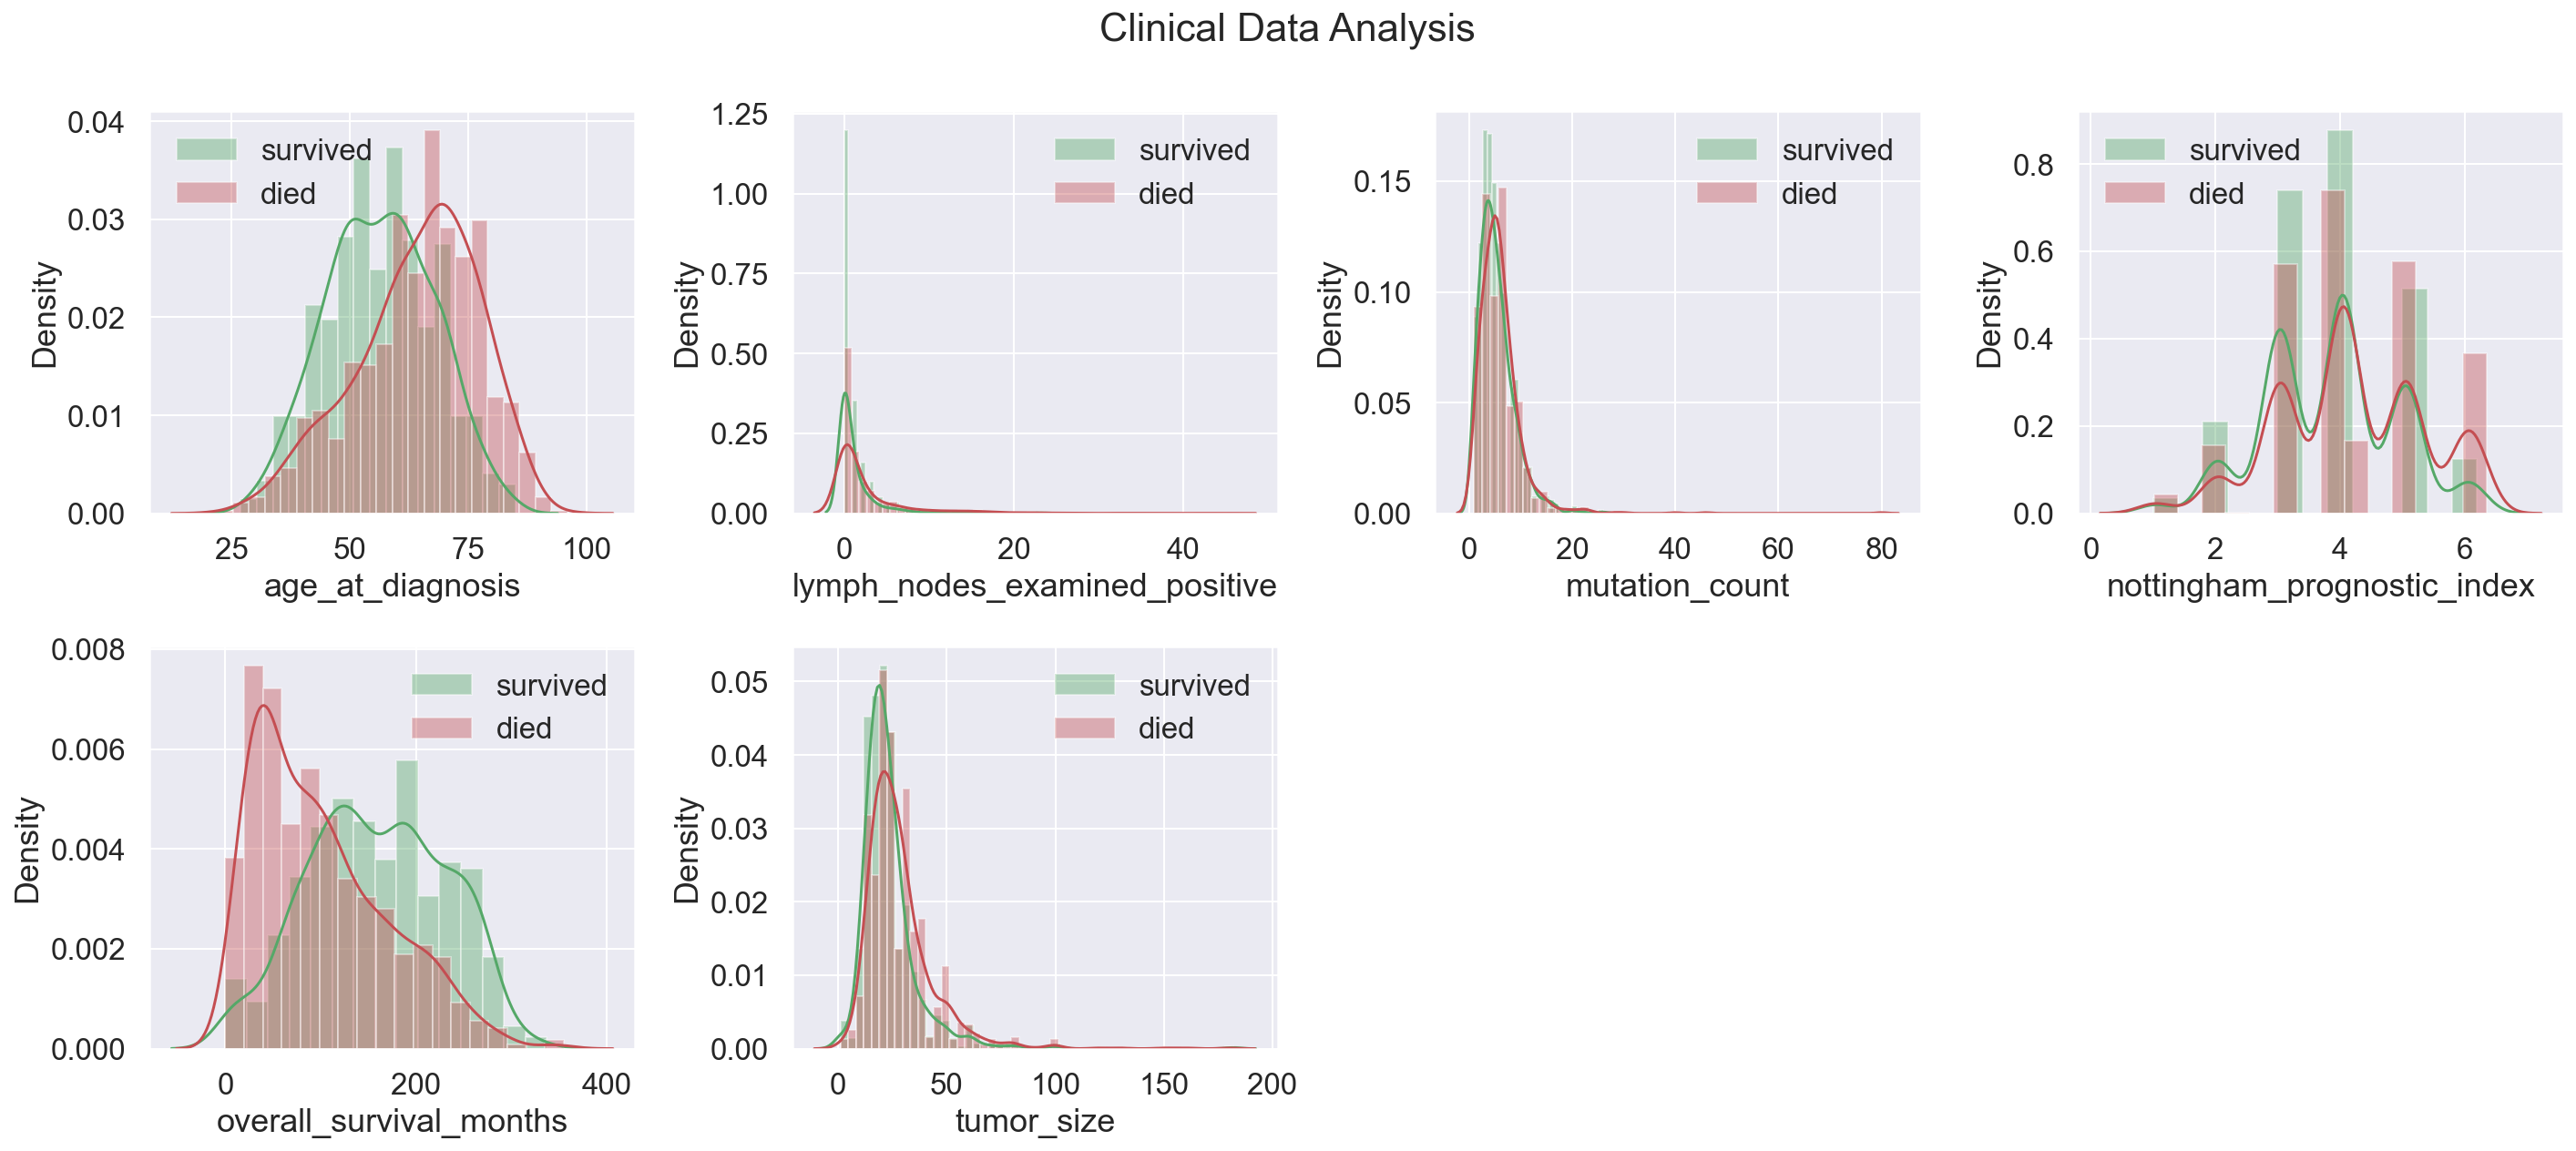

In [61]:
fig = plt.figure(figsize = (20, 25))
j = 0
num_clinical_columns= ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index', 'overall_survival_months', 'tumor_size' ]
for i in clinical_df[num_clinical_columns].columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(clinical_df[i][clinical_df['overall_survival']==1], color='g', label = 'survived')
    sns.distplot(clinical_df[i][clinical_df['overall_survival']==0], color='r', label = 'died')
    plt.legend(loc='best')
fig.suptitle('Clinical Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

- #### Visualizations Clinical Columns in the Dataframe

In [62]:
died = clinical_df[clinical_df['overall_survival']==0]
survived = clinical_df[clinical_df['overall_survival']==1]

alive = clinical_df[clinical_df['death_from_cancer']=='Living']
died_cancer = clinical_df[clinical_df['death_from_cancer']=='Died of Disease']
died_not_cancer = clinical_df[clinical_df['death_from_cancer']=='Died of Other Causes']

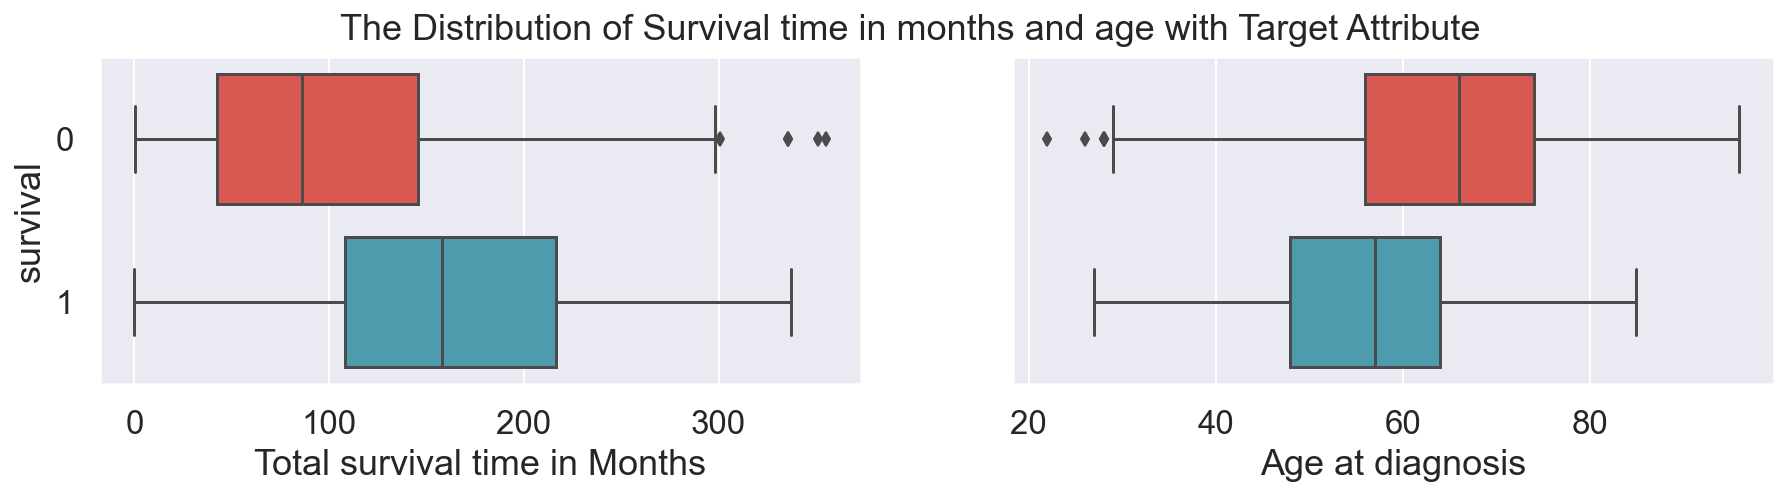

In [63]:
fig, ax = plt.subplots(ncols=2, figsize=(15,3), sharey=True)

sns.boxplot(x='overall_survival_months', y='overall_survival', orient='h', data=clinical_df, ax=ax[0], palette = two_colors, saturation=0.90)
sns.boxplot(x='age_at_diagnosis', y='overall_survival', orient='h', data=clinical_df, ax=ax[1], palette = two_colors, saturation=0.90)

fig.suptitle('The Distribution of Survival time in months and age with Target Attribute', fontsize = 18)

ax[0].set_xlabel('Total survival time in Months')
ax[0].set_ylabel('survival')
ax[1].set_xlabel('Age at diagnosis')
ax[1].set_ylabel('')

plt.show()

To compare between the two classes of patients who survived and patients who did not, we can see the difference between the two distributions in age_at_diagnosis column, as patients who were younger when diagnosed with breast cancer were more likely to survive. Also, the duration from the time of the intervention to death or to current time is longer in the patients who survive. That means that pateints are either dying early from breast cancer or surviving.

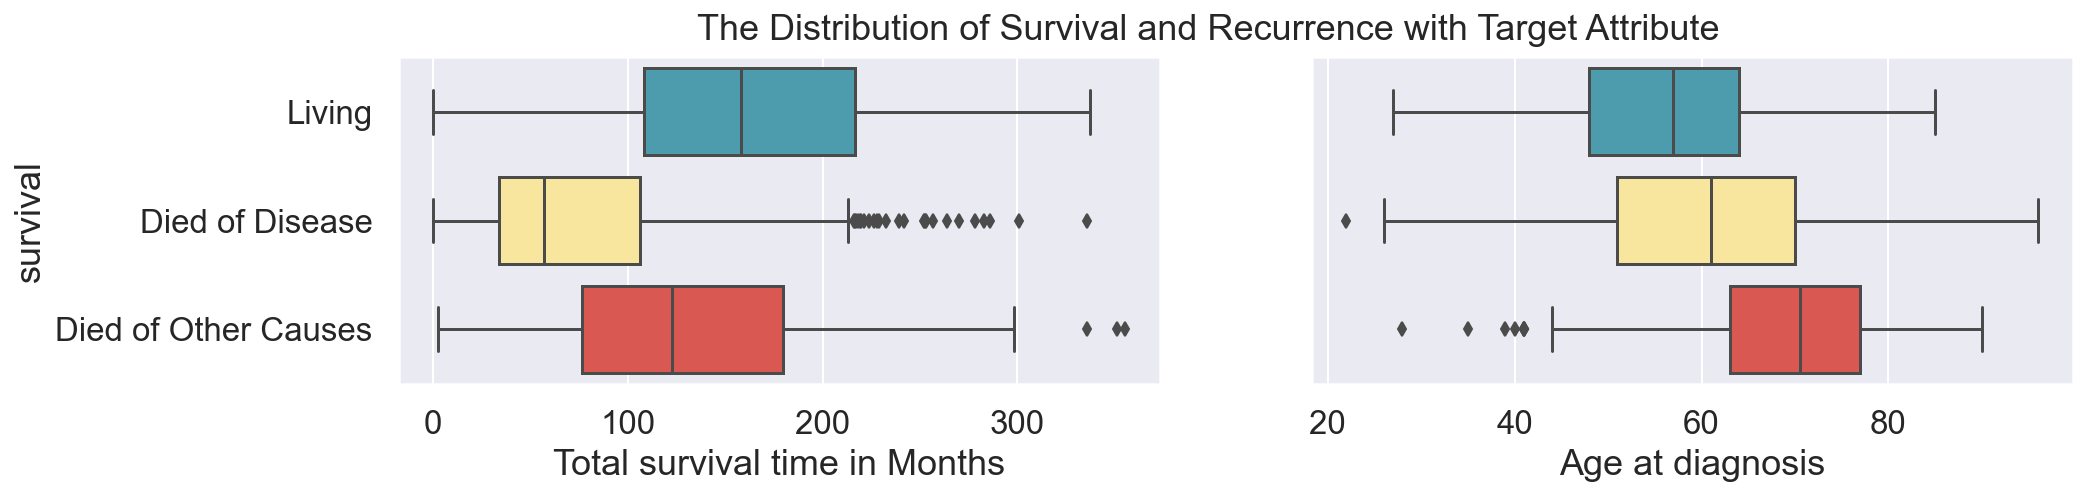

In [64]:
fig, ax = plt.subplots(ncols=2, figsize=(15,3), sharey=True)

sns.boxplot(x='overall_survival_months', y='death_from_cancer', orient='h', data=clinical_df, ax=ax[0], palette = three_colors, saturation=0.90)
sns.boxplot(x='age_at_diagnosis', y='death_from_cancer', orient='h', data=clinical_df, ax=ax[1], palette = three_colors, saturation=0.90)

fig.suptitle('The Distribution of Survival and Recurrence with Target Attribute', fontsize = 18)

ax[0].set_xlabel('Total survival time in Months')
ax[0].set_ylabel('survival')
ax[1].set_xlabel('Age at diagnosis')
ax[1].set_ylabel('')

plt.show()

The variable 'death_from_cancer' shows us if the patient is alive or died from cancer or its complications or died of other causes. From the distribution of the three classes, we can see that the median of the survival time in months of patients who died from breast cancer is low compared to the other two classes, and its distribution os right-skewed with a lot of outliers. Also, patients who died from other causes than cancer tend to be older than the other two classes. The distribution of it is left-skewed with some younger outliers.

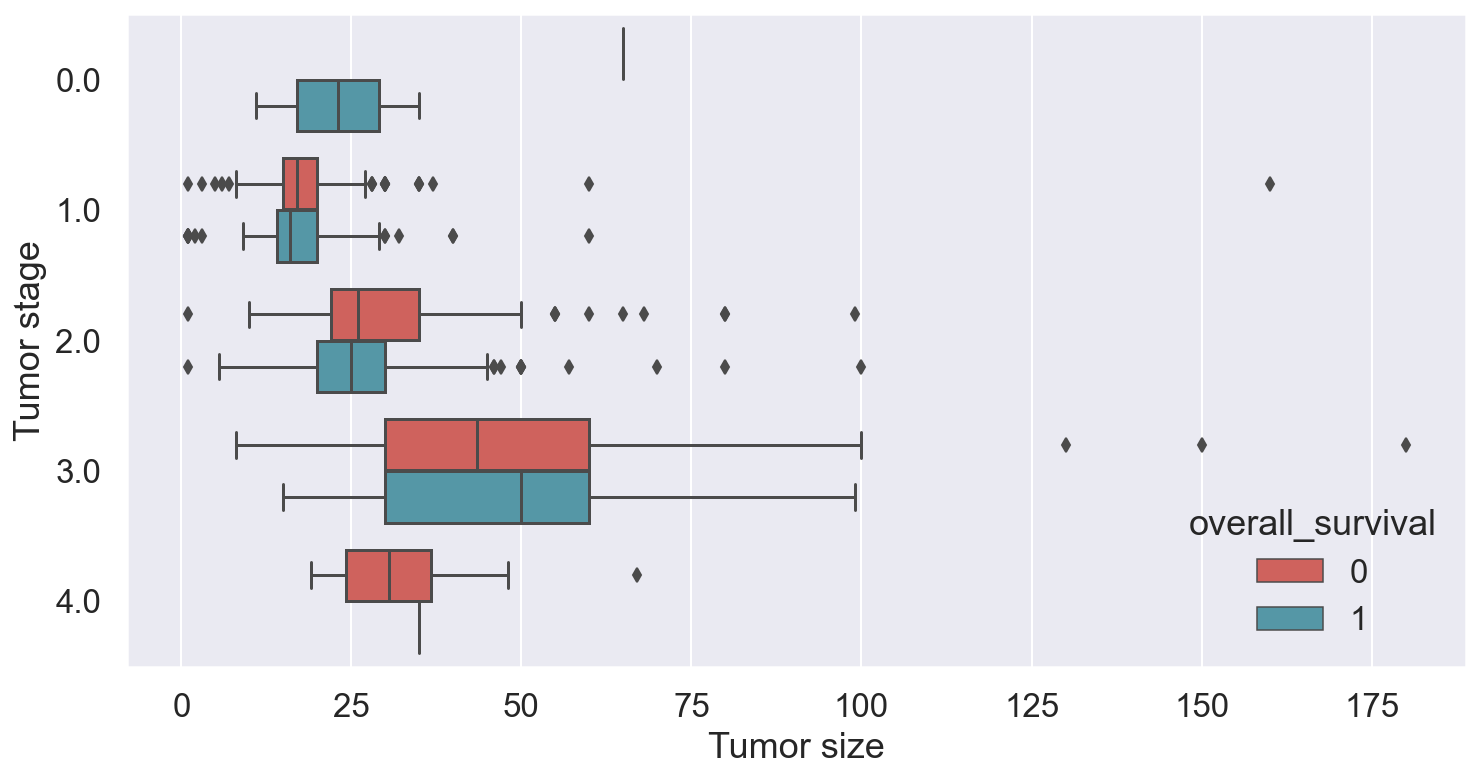

In [65]:
ig, ax = plt.subplots( figsize=(12, 6))
ax = sns.boxplot(x ='tumor_size', y ='tumor_stage',  data = clinical_df, orient='h', hue='overall_survival', palette=two_colors)

ax.set_ylabel('Tumor stage')
ax.set_xlabel('Tumor size')
fig.suptitle('Tumor stage vs. Tumor size and overall_survival', fontsize=20)

#legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

As the Tumer stage increases the tumor size increases as well. Also, if lower tumor stages the probability of survival is higher than when the patient reaches the fourth stage 

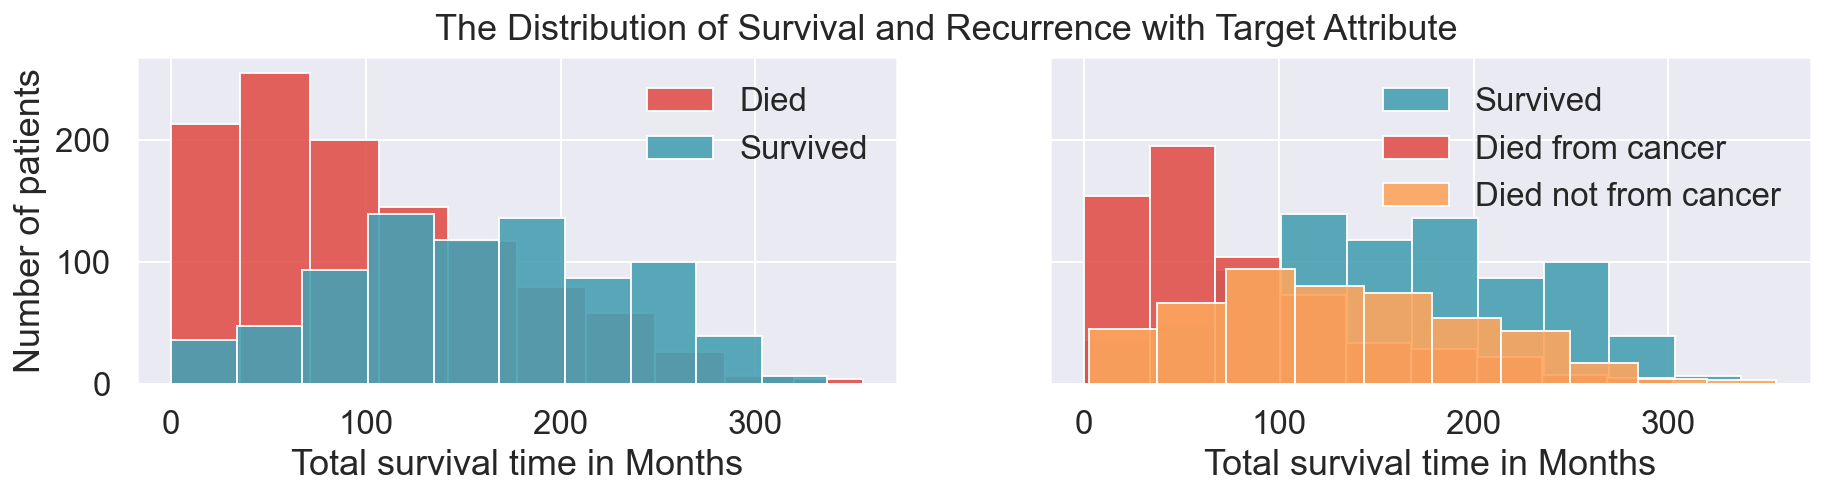

In [66]:
fig, ax = plt.subplots(ncols=2, figsize=(15,3), sharey=True)

fig.suptitle('The Distribution of Survival and Recurrence with Target Attribute', fontsize = 18)

ax[0].hist(died['overall_survival_months'], alpha=0.9, color=sns.color_palette(color)[0], label='Died')
ax[0].hist(survived['overall_survival_months'], alpha=0.9, color=sns.color_palette(color)[5], label='Survived')
ax[0].legend()

ax[1].hist(alive['overall_survival_months'], alpha=0.9, color=sns.color_palette(color)[5], label='Survived')
ax[1].hist(died_cancer['overall_survival_months'], alpha=0.9, color=sns.color_palette(color)[0], label='Died from cancer')
ax[1].hist(died_not_cancer['overall_survival_months'], alpha=0.9, color=sns.color_palette(color)[1], label='Died not from cancer')
ax[1].legend()

ax[0].set_xlabel('Total survival time in Months')
ax[0].set_ylabel('Number of patients')
ax[1].set_xlabel('Total survival time in Months')
ax[1].set_ylabel('')

plt.show()

When the total survival time in months increases, the probability of survival increases as well, and the probability of dying from reasons other than cancer decrease with time slightly.

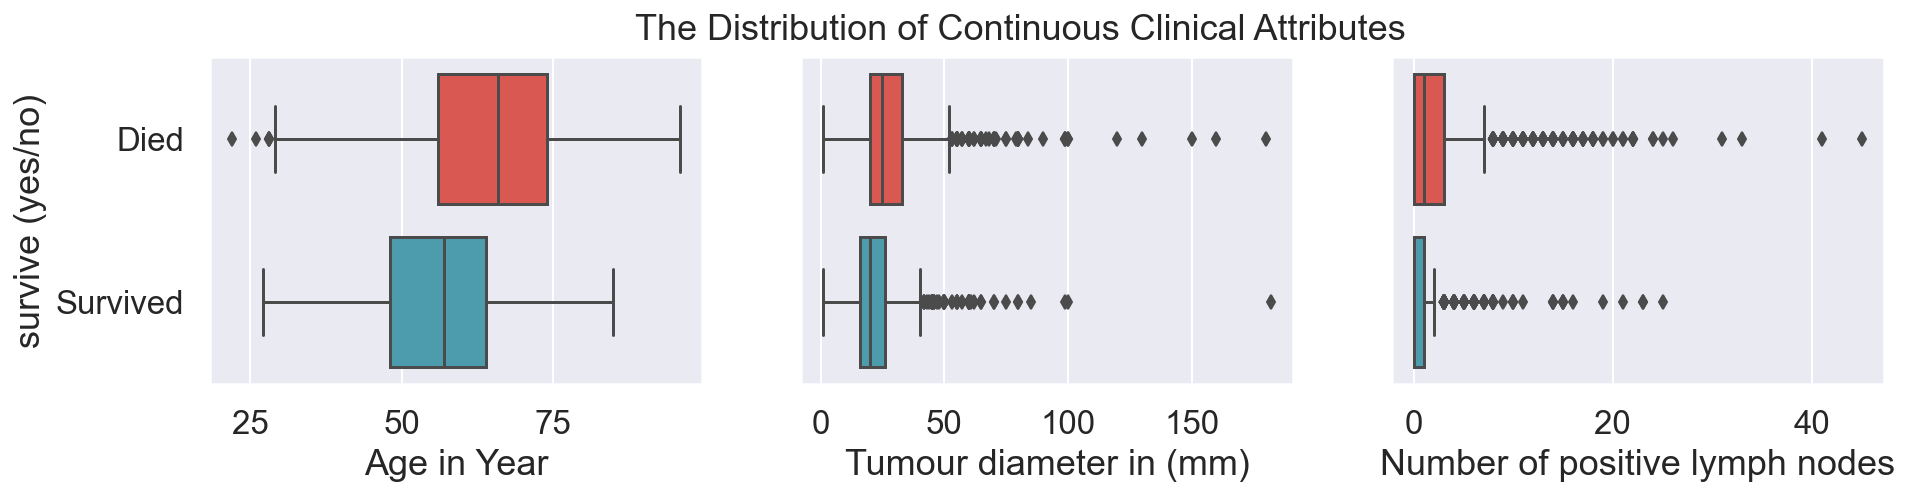

In [67]:
fig, ax = plt.subplots(ncols=3, figsize=(15,3), sharey=True)

sns.boxplot(x='age_at_diagnosis', y='overall_survival', orient='h', data=clinical_df, ax=ax[0], palette = two_colors, saturation=0.90)
sns.boxplot(x='tumor_size', y='overall_survival', orient='h', data=clinical_df, ax=ax[1], palette = two_colors, saturation=0.90)
sns.boxplot(x='lymph_nodes_examined_positive', y='overall_survival', orient='h', data=clinical_df, ax=ax[2], palette = two_colors, saturation=0.90)

fig.suptitle('The Distribution of Continuous Clinical Attributes', fontsize = 18)
plt.yticks([-0.5, 0, 1, 1.5], ['','Died', 'Survived',''])
ax[0].set_xlabel('Age in Year')
ax[0].set_ylabel('survive (yes/no)')

ax[1].set_xlabel('Tumour diameter in (mm)')
ax[1].set_ylabel('')

ax[2].set_xlabel('Number of positive lymph nodes')
ax[2].set_ylabel('')

plt.show()

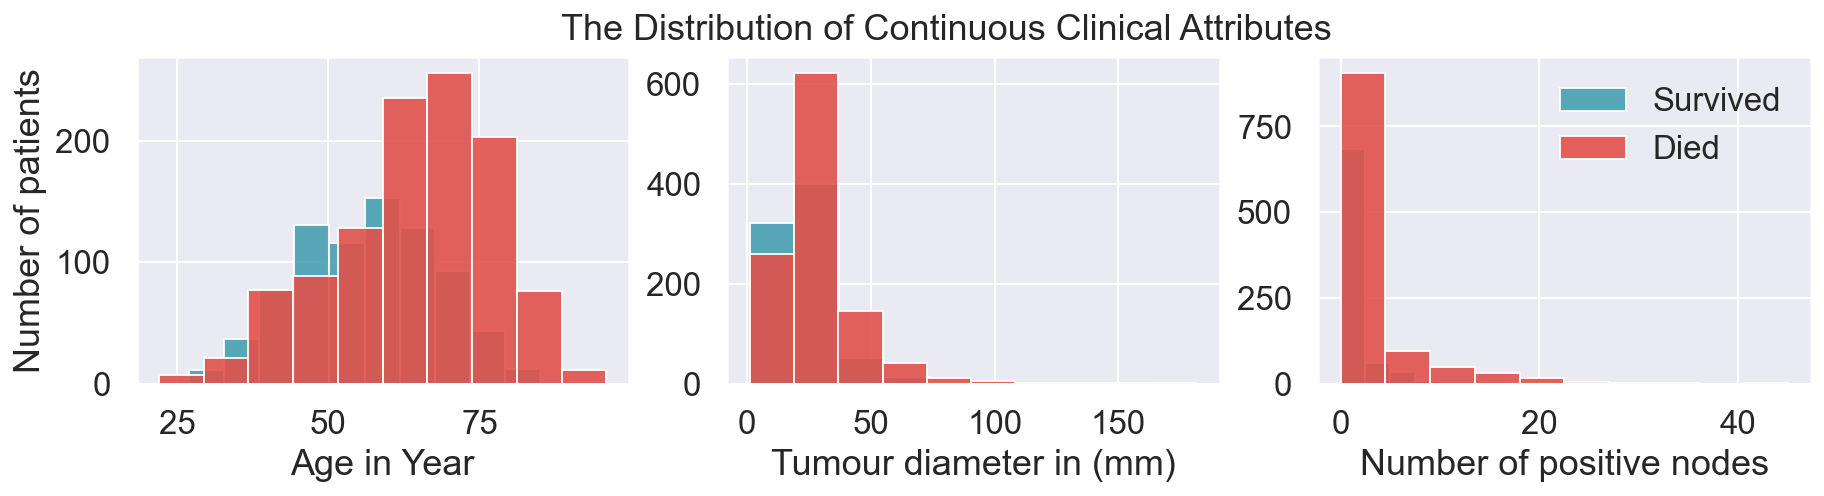

In [68]:
fig, ax = plt.subplots(ncols=3, figsize=(15,3))
fig.suptitle('The Distribution of Continuous Clinical Attributes', fontsize = 18)

ax[0].hist(survived['age_at_diagnosis'], alpha=0.9, color=sns.color_palette(color)[5], label='Survived')
ax[0].hist(died['age_at_diagnosis'], alpha=0.9, color=sns.color_palette(color)[0], label='Died')
#ax[0].legend()

ax[1].hist(survived['tumor_size'], alpha=0.9, color=sns.color_palette(color)[5], label='Survived')
ax[1].hist(died['tumor_size'], alpha=0.9, color=sns.color_palette(color)[0], label='Died')
#ax[1].legend()

ax[2].hist(survived['lymph_nodes_examined_positive'], alpha=0.9, color=sns.color_palette(color)[5], label='Survived')
ax[2].hist(died['lymph_nodes_examined_positive'], alpha=0.9, color=sns.color_palette(color)[0], label='Died')
ax[2].legend()

ax[0].set_xlabel('Age in Year')
ax[0].set_ylabel('Number of patients')
ax[1].set_xlabel('Tumour diameter in (mm)')
ax[1].set_ylabel('')
ax[2].set_xlabel('Number of positive nodes')
ax[2].set_ylabel('')

plt.show()

The median of tumor size and the number of positive lymph nodes is lower in the survived class than the died class.

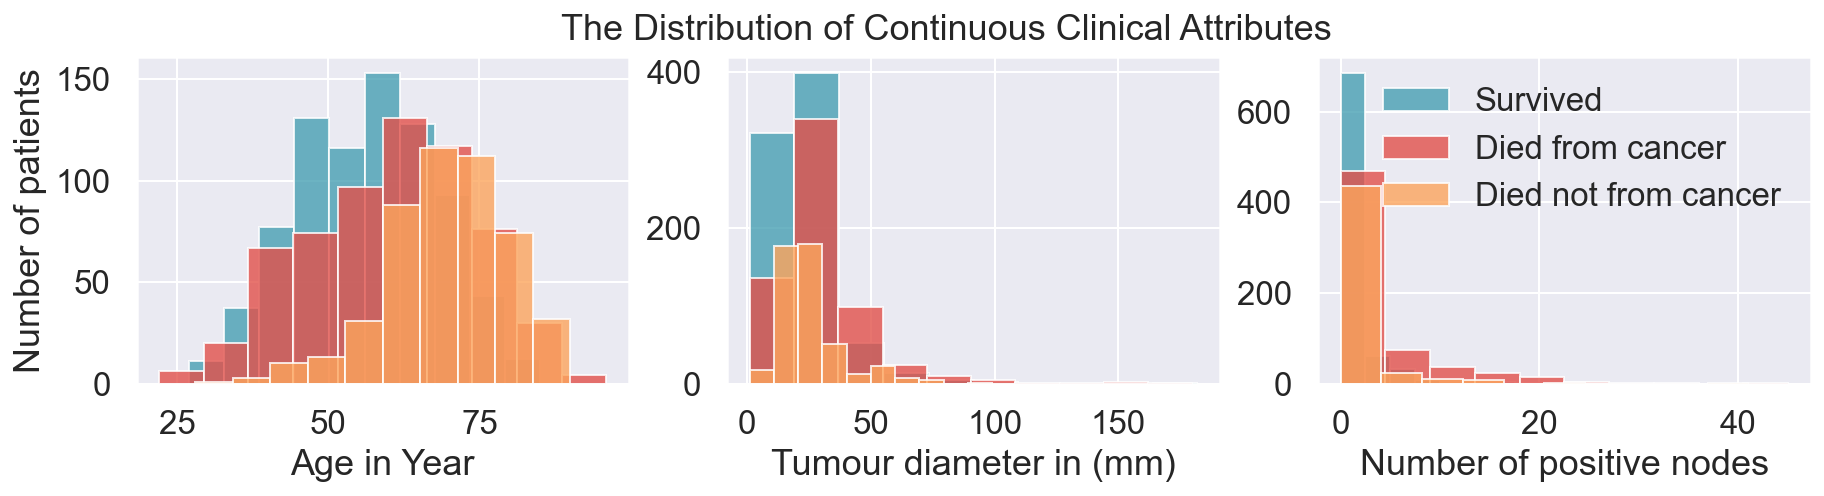

In [69]:
fig, ax = plt.subplots(ncols=3, figsize=(15,3))
fig.suptitle('The Distribution of Continuous Clinical Attributes', fontsize = 18)

ax[0].hist(alive['age_at_diagnosis'], alpha=0.8, color=sns.color_palette(color)[5], label='Survived')
ax[0].hist(died_cancer['age_at_diagnosis'], alpha=0.8, color=sns.color_palette(color)[0], label='Died from cancer')
ax[0].hist(died_not_cancer['age_at_diagnosis'], alpha=0.8, color=sns.color_palette(color)[1], label='Died not from cancer')
#ax[0].legend()

ax[1].hist(alive['tumor_size'], alpha=0.8, color=sns.color_palette(color)[5], label='Survived')
ax[1].hist(died_cancer['tumor_size'], alpha=0.8, color=sns.color_palette(color)[0], label='Died from cancer')
ax[1].hist(died_not_cancer['tumor_size'], alpha=0.8, color=sns.color_palette(color)[1], label='Died not from cancer')
#ax[1].legend()

ax[2].hist(survived['lymph_nodes_examined_positive'], alpha=0.8, color=sns.color_palette(color)[5], label='Survived')
ax[2].hist(died_cancer['lymph_nodes_examined_positive'], alpha=0.8, color=sns.color_palette(color)[0], label='Died from cancer')
ax[2].hist(died_not_cancer['lymph_nodes_examined_positive'], alpha=0.8, color=sns.color_palette(color)[1], label='Died not from cancer')
ax[2].legend()

ax[0].set_xlabel('Age in Year')
ax[0].set_ylabel('Number of patients')
ax[1].set_xlabel('Tumour diameter in (mm)')
ax[1].set_ylabel('')
ax[2].set_xlabel('Number of positive nodes')
ax[2].set_ylabel('')

plt.show()

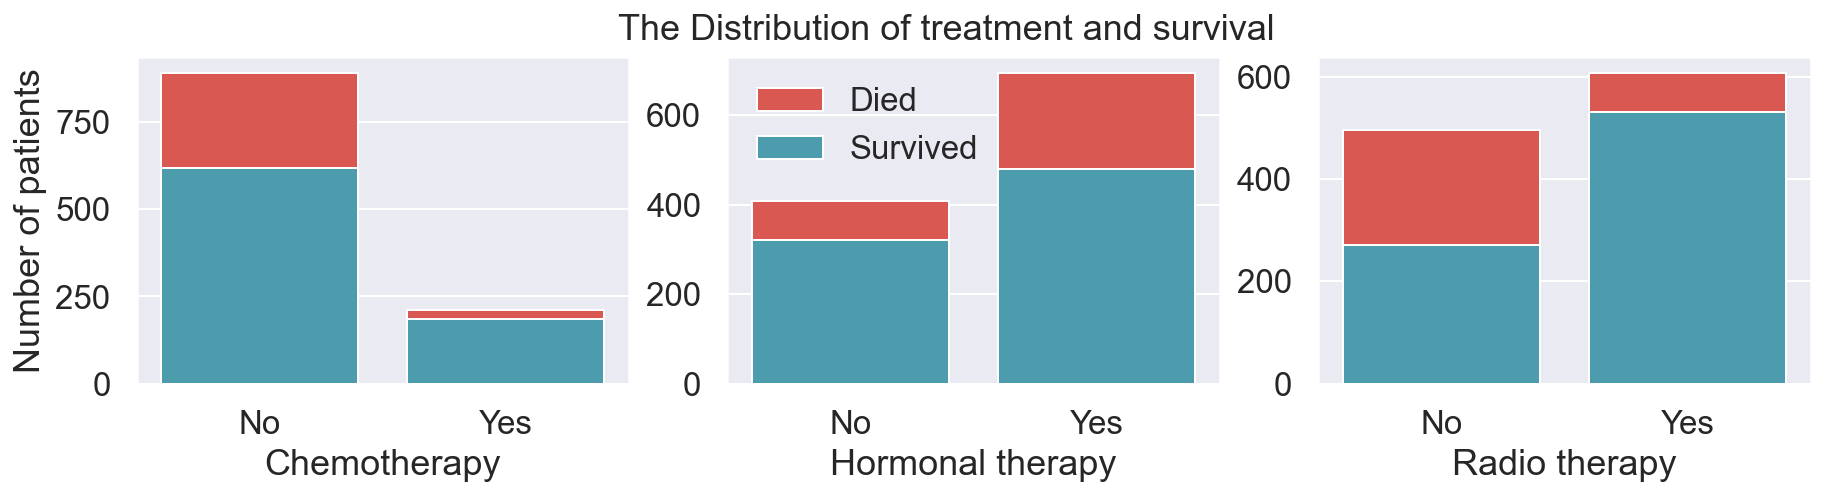

In [70]:
fig, ax = plt.subplots(ncols=3, figsize=(15,3))
fig.suptitle('The Distribution of treatment and survival', fontsize = 18)

sns.countplot(died['chemotherapy'], color=sns.color_palette(color)[0], label='Died', ax=ax[0], saturation=0.90)
sns.countplot(x= survived['chemotherapy'] , color=sns.color_palette(color)[5], label='Survived', ax=ax[0], saturation=0.90)

#ax[0].legend()
ax[0].set(xticklabels=['No','Yes'])

sns.countplot(died['hormone_therapy'], color=sns.color_palette(color)[0], label='Died', ax=ax[1], saturation=0.90)
sns.countplot(x=  survived['hormone_therapy'], color=sns.color_palette(color)[5], label='Survived', ax=ax[1], saturation=0.90)

ax[1].legend()
ax[1].set(xticklabels=['No','Yes'])

sns.countplot(died['radio_therapy'], color=sns.color_palette(color)[0], label='Died', ax=ax[2], saturation=0.90)
sns.countplot(x=  survived['radio_therapy'], color=sns.color_palette(color)[5], label='Survived', ax=ax[2], saturation=0.90)

#ax[2].legend()
ax[2].set(xticklabels=['No','Yes'])

ax[0].set_xlabel('Chemotherapy')
ax[0].set_ylabel('Number of patients')
ax[1].set_xlabel('Hormonal therapy')
ax[1].set_ylabel('')
ax[2].set_xlabel('Radio therapy')
ax[2].set_ylabel('')

plt.show()

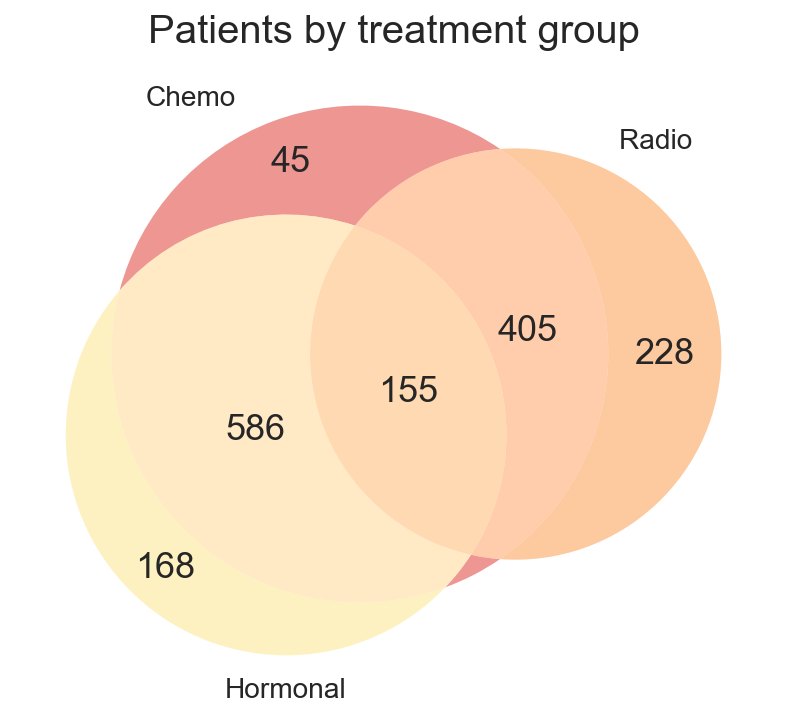

In [71]:
#visualise the treatments and proportion death for other groups using venn diagram

#first create subsets for different combinations of treatments
chemo = clinical_df[(clinical_df["chemotherapy"]==True) & (clinical_df["radio_therapy"]==False) & (clinical_df["hormone_therapy"]==False)]
radio = clinical_df[(clinical_df["chemotherapy"]==False) & (clinical_df["radio_therapy"]==True) & (clinical_df["hormone_therapy"]==False)]
hormonal = clinical_df[(clinical_df["chemotherapy"]==False) & (clinical_df["radio_therapy"]==False) & (clinical_df["hormone_therapy"]==True)]
chemo_radio = clinical_df[(clinical_df["chemotherapy"]==True) & (clinical_df["radio_therapy"]==True) & (clinical_df["hormone_therapy"]==False)]
radio_hormonal = clinical_df[(clinical_df["chemotherapy"]==False) & (clinical_df["radio_therapy"]==True) & (clinical_df["hormone_therapy"]==True)]
hormonal_chemo = clinical_df[(clinical_df["chemotherapy"]==True) & (clinical_df["radio_therapy"]==False) & (clinical_df["hormone_therapy"]==True)]
all_3 = clinical_df[(clinical_df["chemotherapy"]==True) & (clinical_df["radio_therapy"]==True) & (clinical_df["hormone_therapy"]==True)]

#calculate number of people for each combination and proportion death
df_subsets = [chemo, radio, hormonal, chemo_radio, radio_hormonal, hormonal_chemo, all_3]
sizes=[]
proportiondeath=[]
for dataframe in df_subsets:
    sizes.append(np.shape(dataframe)[0])
    proportiondeath.append(np.mean(dataframe["overall_survival"]))

#set size of circles relative to size of each subset (where possible)
#set gradient of blue according to proportion of death in subset calculated above
fig, ax = plt.subplots(figsize=(8,6))
v = venn3(subsets=sizes, set_labels=("Chemo", "Radio ", "Hormonal"), ax=ax, alpha=0.6, set_colors= sns.color_palette(color))

for text in v.set_labels:
    text.set_fontsize(14)
    
ax.set_title("Patients by treatment group", size=20)
plt.show()

Venn diagram for the three different treatments for breast cancer and the distribution of patients amongst them. we can see that most patients either have chemo and hormonal therapy or chemo and radio therapy. there is a group that is not shown here in the diagram, which are the patients that did not receive any of the three treatments. they were 289 patients and their survival rate was slightly lower than the rest of patients. 

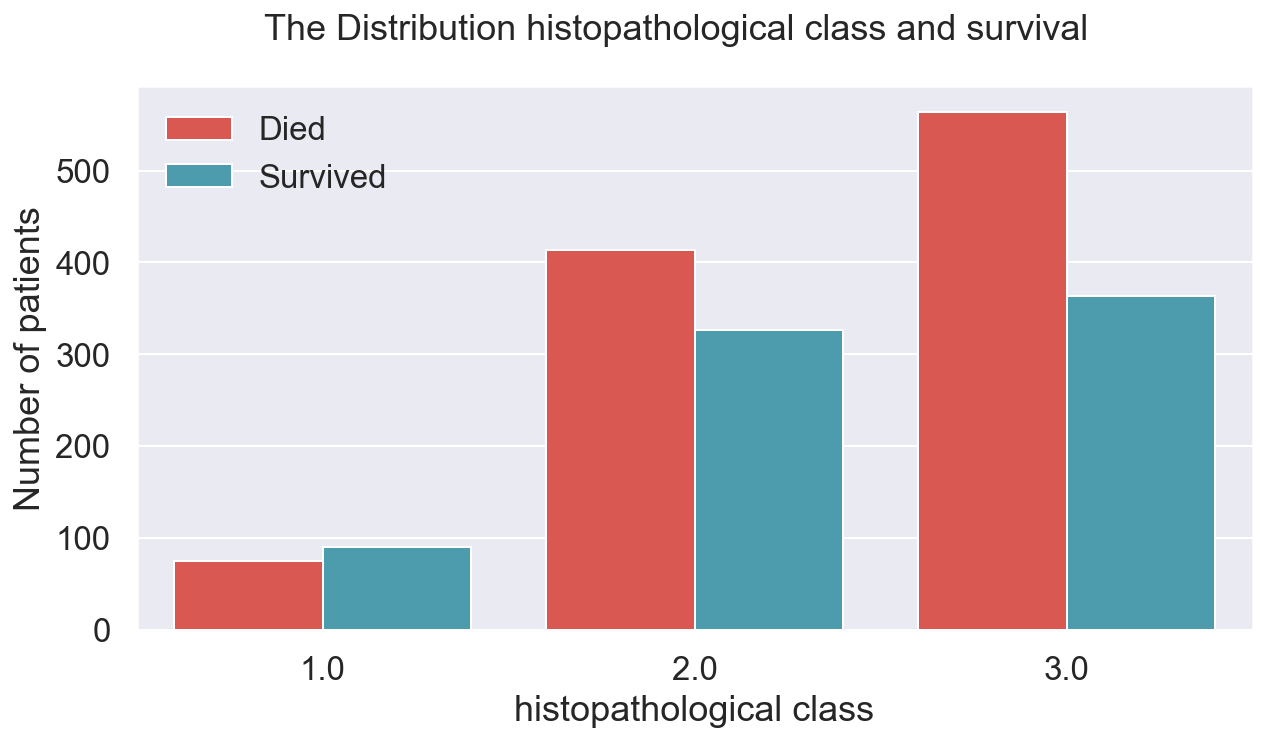

In [72]:
fig, ax = plt.subplots( figsize=(10,5))
fig.suptitle('The Distribution histopathological class and survival', fontsize = 18)

sns.countplot(x='neoplasm_histologic_grade', hue='overall_survival' ,data = clinical_df, palette=two_colors , ax=ax, saturation=0.90)
ax.legend([ 'Died', 'Survived'])

ax.set_xlabel('histopathological class')
ax.set_ylabel('Number of patients')

plt.show()

- #### Visualize Correlation of between the Clinical Attributes

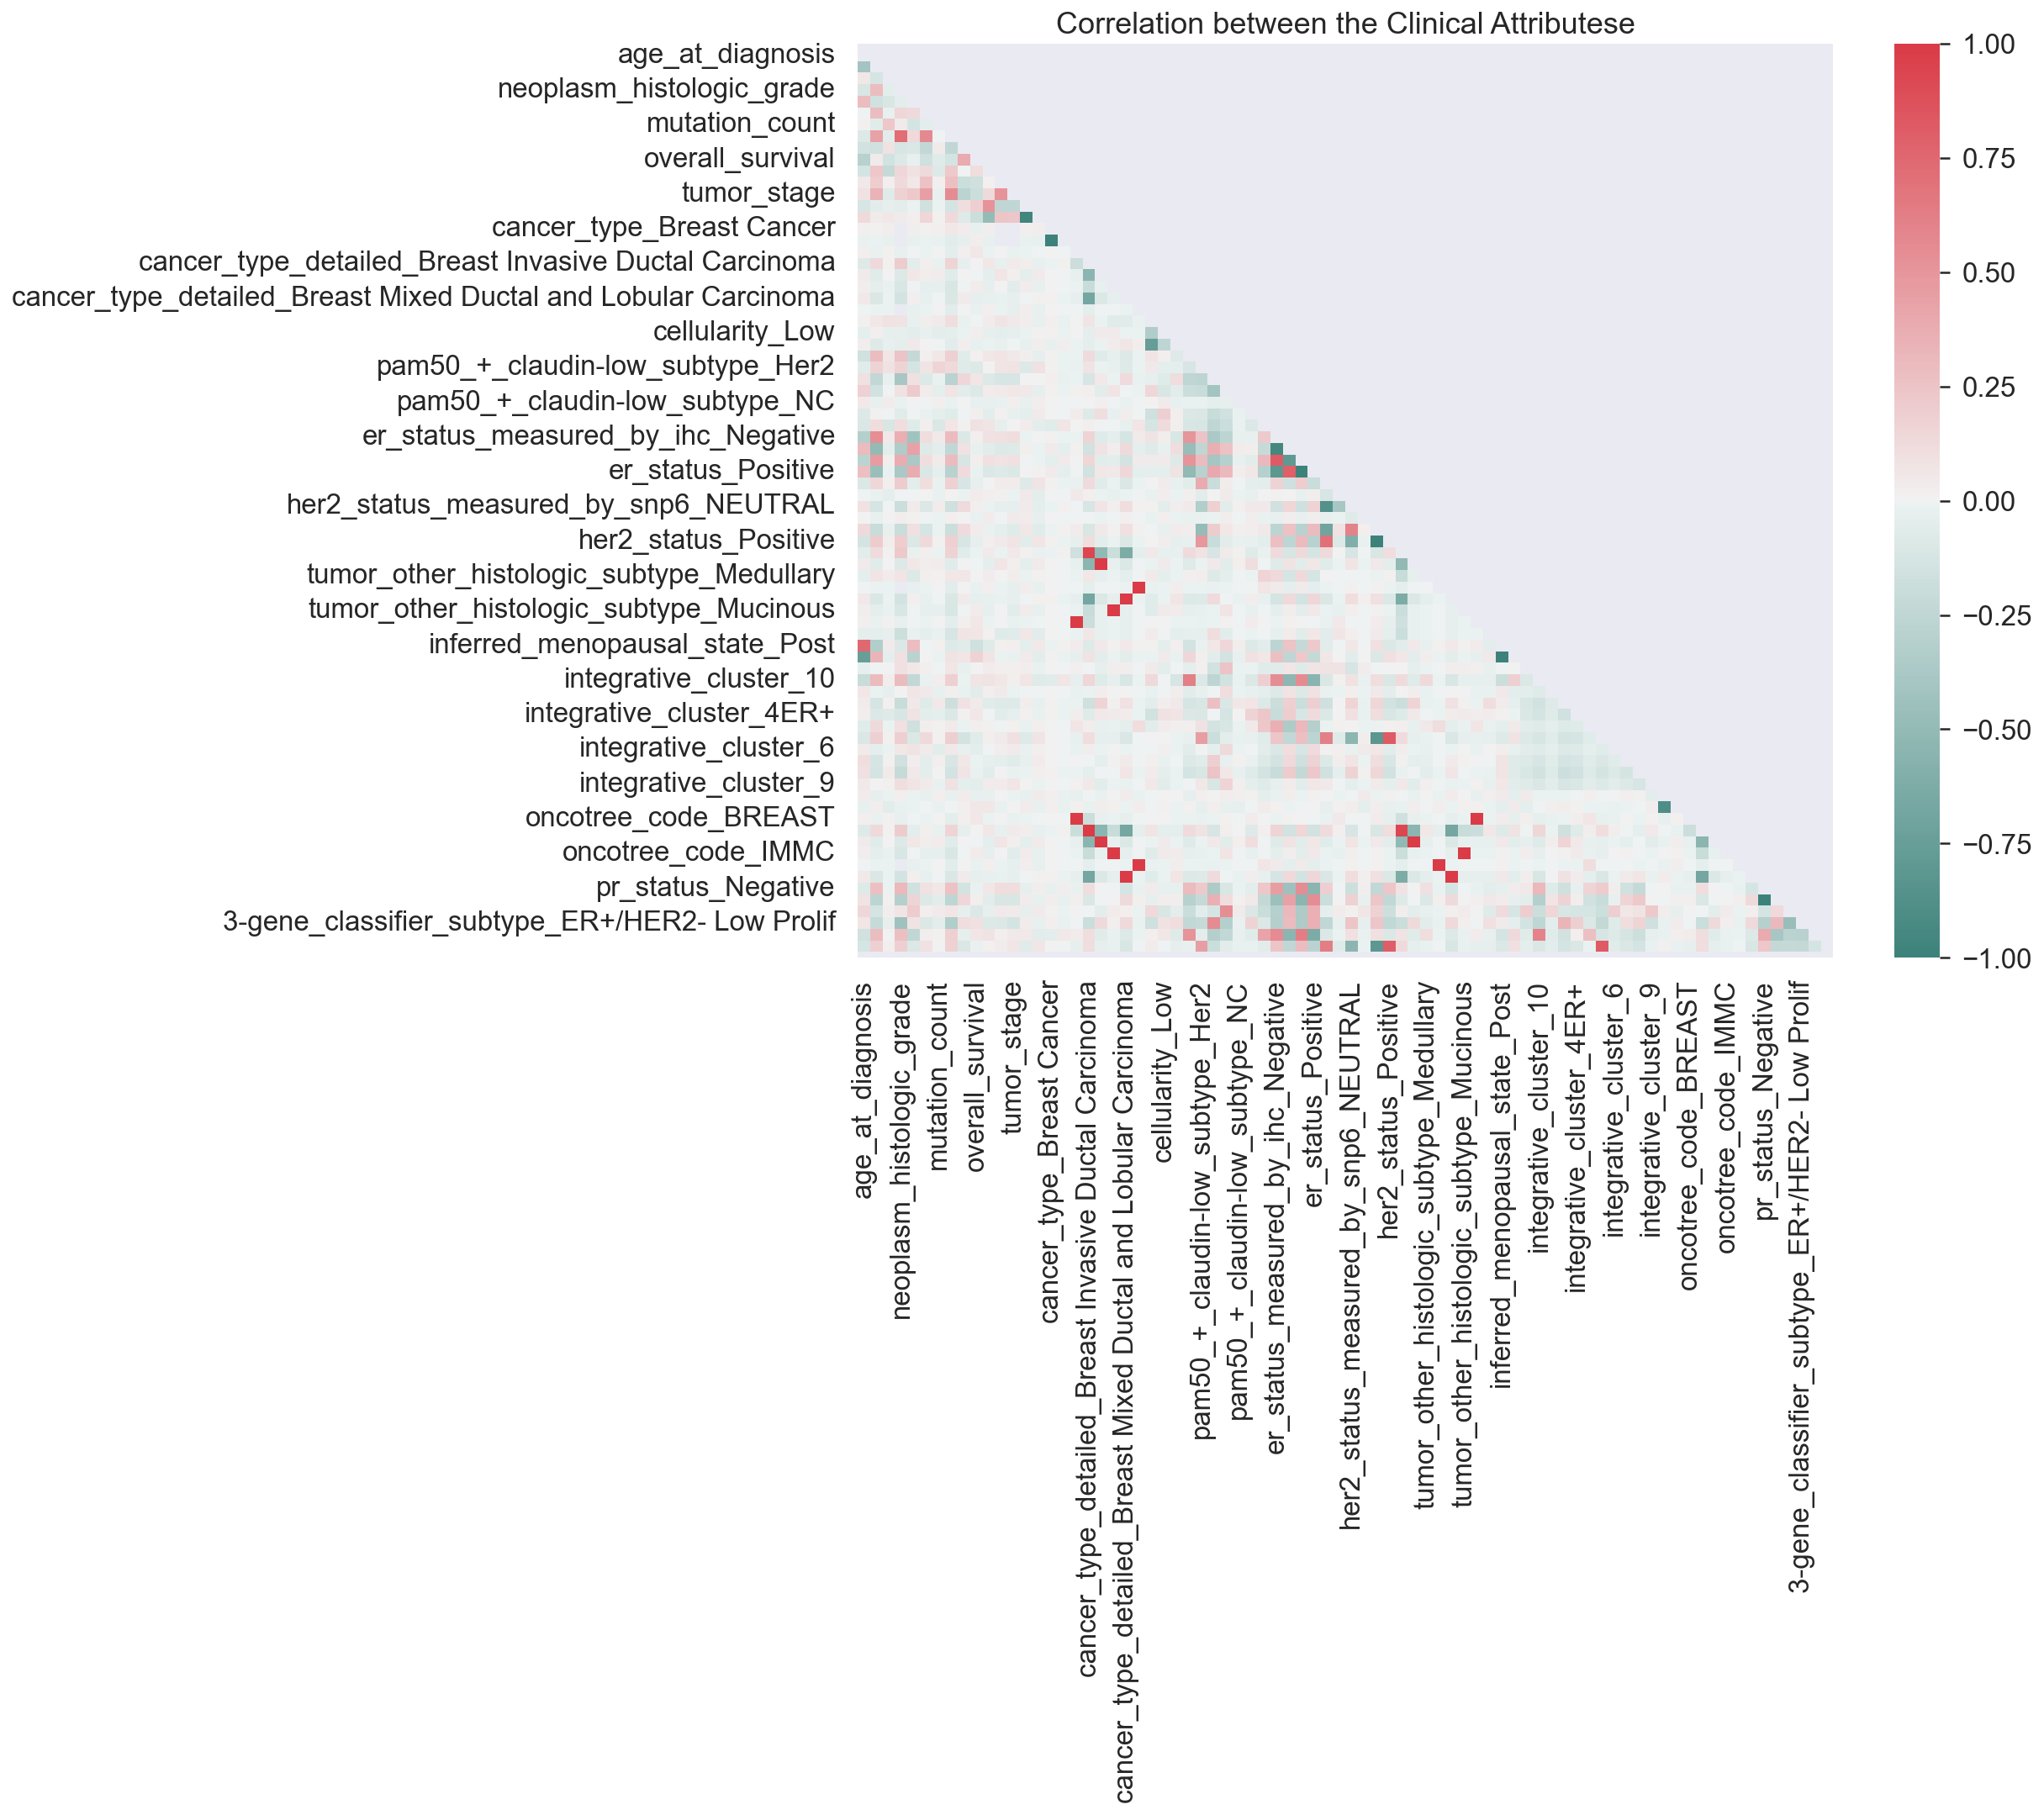

In [73]:
fig, axs = plt.subplots(figsize = (13, 10)) 
categorical_columns = clinical_df.select_dtypes(include=['object']).columns.tolist()
unwanted_columns = ['patient_id','death_from_cancer' ]
categorical_columns = [ele for ele in categorical_columns if ele not in unwanted_columns] 
no_id_clinical_df = pd.get_dummies(clinical_df.drop('patient_id',axis=1 ), columns= categorical_columns)
#no_id_clinical_df= clinical_df.drop('ID',axis=1 )
mask = np.triu(np.ones_like(no_id_clinical_df.corr(), dtype = np.bool))
sns.heatmap(no_id_clinical_df.corr(), ax = axs, mask = mask, cmap = sns.diverging_palette(180, 10, as_cmap = True))
plt.title('Correlation between the Clinical Attributese')

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

We can see that there is high correlation between some of the columns. 

- #### Correlation between the Clinical Attributes and survival

In [74]:
Corr_survival = no_id_clinical_df.corr()['overall_survival'].sort_values(ascending = False)
Corr_df = pd.DataFrame({'Correlation':Corr_survival})
Corr_df.head(10)

Correlation
overall_survival                                   1.000000
overall_survival_months                            0.384467
type_of_breast_surgery_BREAST CONSERVING           0.187856
inferred_menopausal_state_Pre                      0.170915
radio_therapy                                      0.112083
3-gene_classifier_subtype_ER+/HER2- Low Prolif     0.094463
pam50_+_claudin-low_subtype_claudin-low            0.091397
integrative_cluster_10                             0.076256
pam50_+_claudin-low_subtype_LumA                   0.065186
3-gene_classifier_subtype_ER-/HER2-                0.065135

In [75]:
Corr_df.tail()

Correlation
lymph_nodes_examined_positive        -0.164498
inferred_menopausal_state_Post       -0.170915
type_of_breast_surgery_MASTECTOMY    -0.184259
tumor_stage                          -0.188790
age_at_diagnosis                     -0.303060

There is a positive correlation between survival and overall survival in months, conserving surgery type, pre menopaus status, but a negative correlation between survival and lymph nodes examined positive, mastectomy surgery type, tumor stage, and age at diagnosis.

- ####  Statistical Summaries of Clinical Columns in the Dataframe

In [76]:
num_clinical_columns= ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index', 'overall_survival_months', 'tumor_size' ]
cat_clinical_columns = ['chemotherapy', 'cohort', 'neoplasm_histologic_grade','hormone_therapy', 'overall_survival', 'radio_therapy', 'tumor_stage' ]
# Statistical summary for numerical clinical attributes 
clinical_df[num_clinical_columns].describe(). T

count        mean        std   min     25%  \
age_at_diagnosis               1904.0   61.087710  12.975549  22.0  51.000   
lymph_nodes_examined_positive  1904.0    2.002101   4.079993   0.0   0.000   
mutation_count                 1859.0    5.697687   4.058778   1.0   3.000   
nottingham_prognostic_index    1904.0    4.033019   1.144492   1.0   3.046   
overall_survival_months        1904.0  125.121324  76.334148   0.0  60.825   
tumor_size                     1884.0   26.238726  15.160976   1.0  17.000   

                                      50%         75%     max  
age_at_diagnosis                62.000000   71.000000   96.00  
lymph_nodes_examined_positive    0.000000    2.000000   45.00  
mutation_count                   5.000000    7.000000   80.00  
nottingham_prognostic_index      4.042000    5.040250    6.36  
overall_survival_months        115.616667  184.716667  355.20  
tumor_size                      23.000000   30.000000  182.00

In [77]:
# Statistical summary for categorical clinical attributes 
cat_clinical_columns.extend(clinical_df.select_dtypes(include=['object']).columns.tolist())
clinical_df[cat_clinical_columns].astype('category').describe().T

count unique  \
chemotherapy                      1904      2   
cohort                            1904      5   
neoplasm_histologic_grade       1832.0    3.0   
hormone_therapy                   1904      2   
overall_survival                  1904      2   
radio_therapy                     1904      2   
tumor_stage                     1403.0    5.0   
type_of_breast_surgery            1882      2   
cancer_type                       1904      2   
cancer_type_detailed              1889      6   
cellularity                       1850      3   
pam50_+_claudin-low_subtype       1904      7   
er_status_measured_by_ihc         1874      2   
er_status                         1904      2   
her2_status_measured_by_snp6      1904      4   
her2_status                       1904      2   
tumor_other_histologic_subtype    1889      8   
inferred_menopausal_state         1904      2   
integrative_cluster               1904     11   
primary_tumor_laterality          1798      2   
oncotree_code                     1889      6   
pr_status                         1904      2   
3-gene_classifier_subtype         1700      4   
death_from_cancer                 1903      3   

                                                             top   freq  
chemotherapy                                                   0   1508  
cohort                                                         3    734  
neoplasm_histologic_grade                                    3.0  927.0  
hormone_therapy                                                1   1174  
overall_survival                                               0   1103  
radio_therapy                                                  1   1137  
tumor_stage                                                  2.0  800.0  
type_of_breast_surgery                                MASTECTOMY   1127  
cancer_type                                        Breast Cancer   1903  
cancer_type_detailed            Breast Invasive Ductal Carcinoma   1500  
cellularity                                                 High    939  
pam50_+_claudin-low_subtype                                 LumA    679  
er_status_measured_by_ihc                                Positve   1445  
er_status                                               Positive   1459  
her2_status_measured_by_snp6                             NEUTRAL   1383  
her2_status                                             Negative   1668  
tumor_other_histologic_subtype                        Ductal/NST   1454  
inferred_menopausal_state                                   Post   1493  
integrative_cluster                                            8    289  
primary_tumor_laterality                                    Left    935  
oncotree_code                                                IDC   1500  
pr_status                                               Positive   1009  
3-gene_classifier_subtype                   ER+/HER2- Low Prolif    619  
death_from_cancer                                         Living    801

In [78]:
#statistics for the no treatment group and comparison with the baseline
no_treatment = clinical_df[(clinical_df['chemotherapy']==0) & (clinical_df['hormone_therapy']==0) & (clinical_df['radio_therapy']==0)]
print("Number of patients who had no treatment: " , no_treatment.shape[0])
print("Proportion of survival in this group: " , ("%.3f" %np.mean(no_treatment["overall_survival"])))
print("Baseline Proportion of survival in all groups: ", ("%.3f" %np.mean(clinical_df["overall_survival"])))

Number of patients who had no treatment:  289
Proportion of survival in this group:  0.381
Baseline Proportion of survival in all groups:  0.421


- #### What are the characteristics of the average member of the population?

In [79]:
#what the average patient looks like
print("Mean age: " + "%.3f" %np.mean(clinical_df['age_at_diagnosis']))
print("Most occurring tumour stage: " , stats.mode(clinical_df['tumor_stage'])[0][0].astype(int))
print("Most occurring histopathological type: " , stats.mode(clinical_df['neoplasm_histologic_grade'])[0][0].astype(int))
print("Mean tumour diameter: " + "%.3f" %np.mean(clinical_df['tumor_size']))
print("Probability of survival: "+ "%.3f" %(clinical_df["overall_survival"].value_counts()/clinical_df["overall_survival"].count()).iloc[1])

Mean age: 61.088
Most occurring tumour stage:  2
Most occurring histopathological type:  3
Mean tumour diameter: 26.239
Probability of survival: 0.421


The average breast cancer patient in the dataset is a 61-year-old women with a stage 2 tumor with 2 lymph nodes examined positive, with a mean tumor size of 26 mm. The patient has a probability of 76% of not having chemotherapy as a treatment, but only hormonal and radiotherapy with surgery.

- #### Number of outliers in each clinical feature

In [80]:
#Finding number of outliers in each column
Q1 = clinical_df.quantile(0.25)
Q3 = clinical_df.quantile(0.75)
IQR = Q3 - Q1
((clinical_df < (Q1 - 1.5 * IQR)) | (clinical_df > (Q3 + 1.5 * IQR))).sum().sort_values(ascending = False).head(7)

chemotherapy                      396
lymph_nodes_examined_positive     210
tumor_size                        142
mutation_count                     62
tumor_stage                         9
tumor_other_histologic_subtype      0
radio_therapy                       0
dtype: int64

<a name="genetic"></a>
### b) Relationship between genetic attributes and outcomes

In [81]:
# dropping mutations
genetic_features_to_drop = df.columns[520:]
genetic_df = df.drop(genetic_features_to_drop, axis=1)
# droping clinical data
genetic_features_to_drop = genetic_df.columns[4:35]
genetic_df = genetic_df.drop(genetic_features_to_drop, axis=1)
genetic_df = genetic_df.drop(['age_at_diagnosis','type_of_breast_surgery', 'cancer_type'], axis=1)
genetic_df = genetic_df.iloc [:,:-174]
genetic_df['overall_survival']= df['overall_survival']

genetic_df.head()

patient_id    tp53     atm    cdh1   chek2     nbn     nf1   stk11   bard1  \
0           0  0.3504  1.1517  0.0348  0.1266 -0.8361 -0.8578 -0.4294 -1.1201   
1           2 -0.0136 -0.2659  1.3594  0.7961  0.5419 -2.6059  0.5120  0.4390   
2           5  0.5141 -0.0803  1.1398  0.4187 -0.4030 -1.1305  0.2362 -0.1721   
3           6  1.6708 -0.8880  1.2491 -1.1889 -0.4174 -0.6165  1.0078 -0.4010   
4           8  0.3484  0.3897  0.9131  0.9356  0.7675 -0.2940 -0.2961  0.6320   

     mlh1  ...  tubb4a  tubb4b  twist1  adgra2    afdn    aff2    agmo  \
0 -0.4844  ... -0.0250 -0.4113  2.8096  2.8014 -0.0004  0.9673  0.3011   
1  1.2266  ... -0.1003  0.7791 -0.2273 -0.4462 -1.9854  0.5022 -0.9526   
2 -1.7910  ...  1.2084 -0.6572  0.1984 -1.0721 -0.9729  0.0515  0.1109   
3 -1.3905  ...  0.3142 -0.4413  0.1932 -1.0215  0.4553 -0.2354  0.4003   
4 -0.3582  ... -0.6606 -1.4697  0.4128 -1.5326 -0.4795  1.0052  0.9739   

    agtr2   ahnak  overall_survival  
0 -0.8436  1.8227                 1  
1 -1.8435  1.6662                 1  
2  0.9874 -0.0154                 0  
3  1.4839  0.3101                 1  
4  0.8825 -0.7598                 0  

[5 rows x 313 columns]

In [82]:
#Finding Maximum values and std in each column, std is always 1 because the datapoints are z-scores
max_values = genetic_df.max()
std = genetic_df.std(axis = 0, skipna = True)
max_data = pd.concat([max_values, std], axis = 1, keys = ['max_values', 'std'])
max_data.sort_values(by='max_values', ascending = False).head()

max_values          std
patient_id   7299.0000  2358.478332
tubb4a         18.6351     1.000263
hes5           17.1431     1.000262
itgb3          15.3308     1.000263
slco1b3        14.8651     1.000262

In [83]:
#Finding minimum values and std in each column, std is always 1 because the datapoints are z-scores
min_values = genetic_df.min()
std = genetic_df.std(axis = 0, skipna = True)
min_data = pd.concat([min_values, std], axis = 1, keys = ['min_values', 'std'])
min_data.sort_values(by='min_values', ascending = True).head()

min_values       std
mlh1      -6.4387  1.000262
rab25     -6.3503  1.000264
hdac1     -5.9821  1.000263
spen      -5.9510  1.000263
foxo3     -5.7543  1.000263

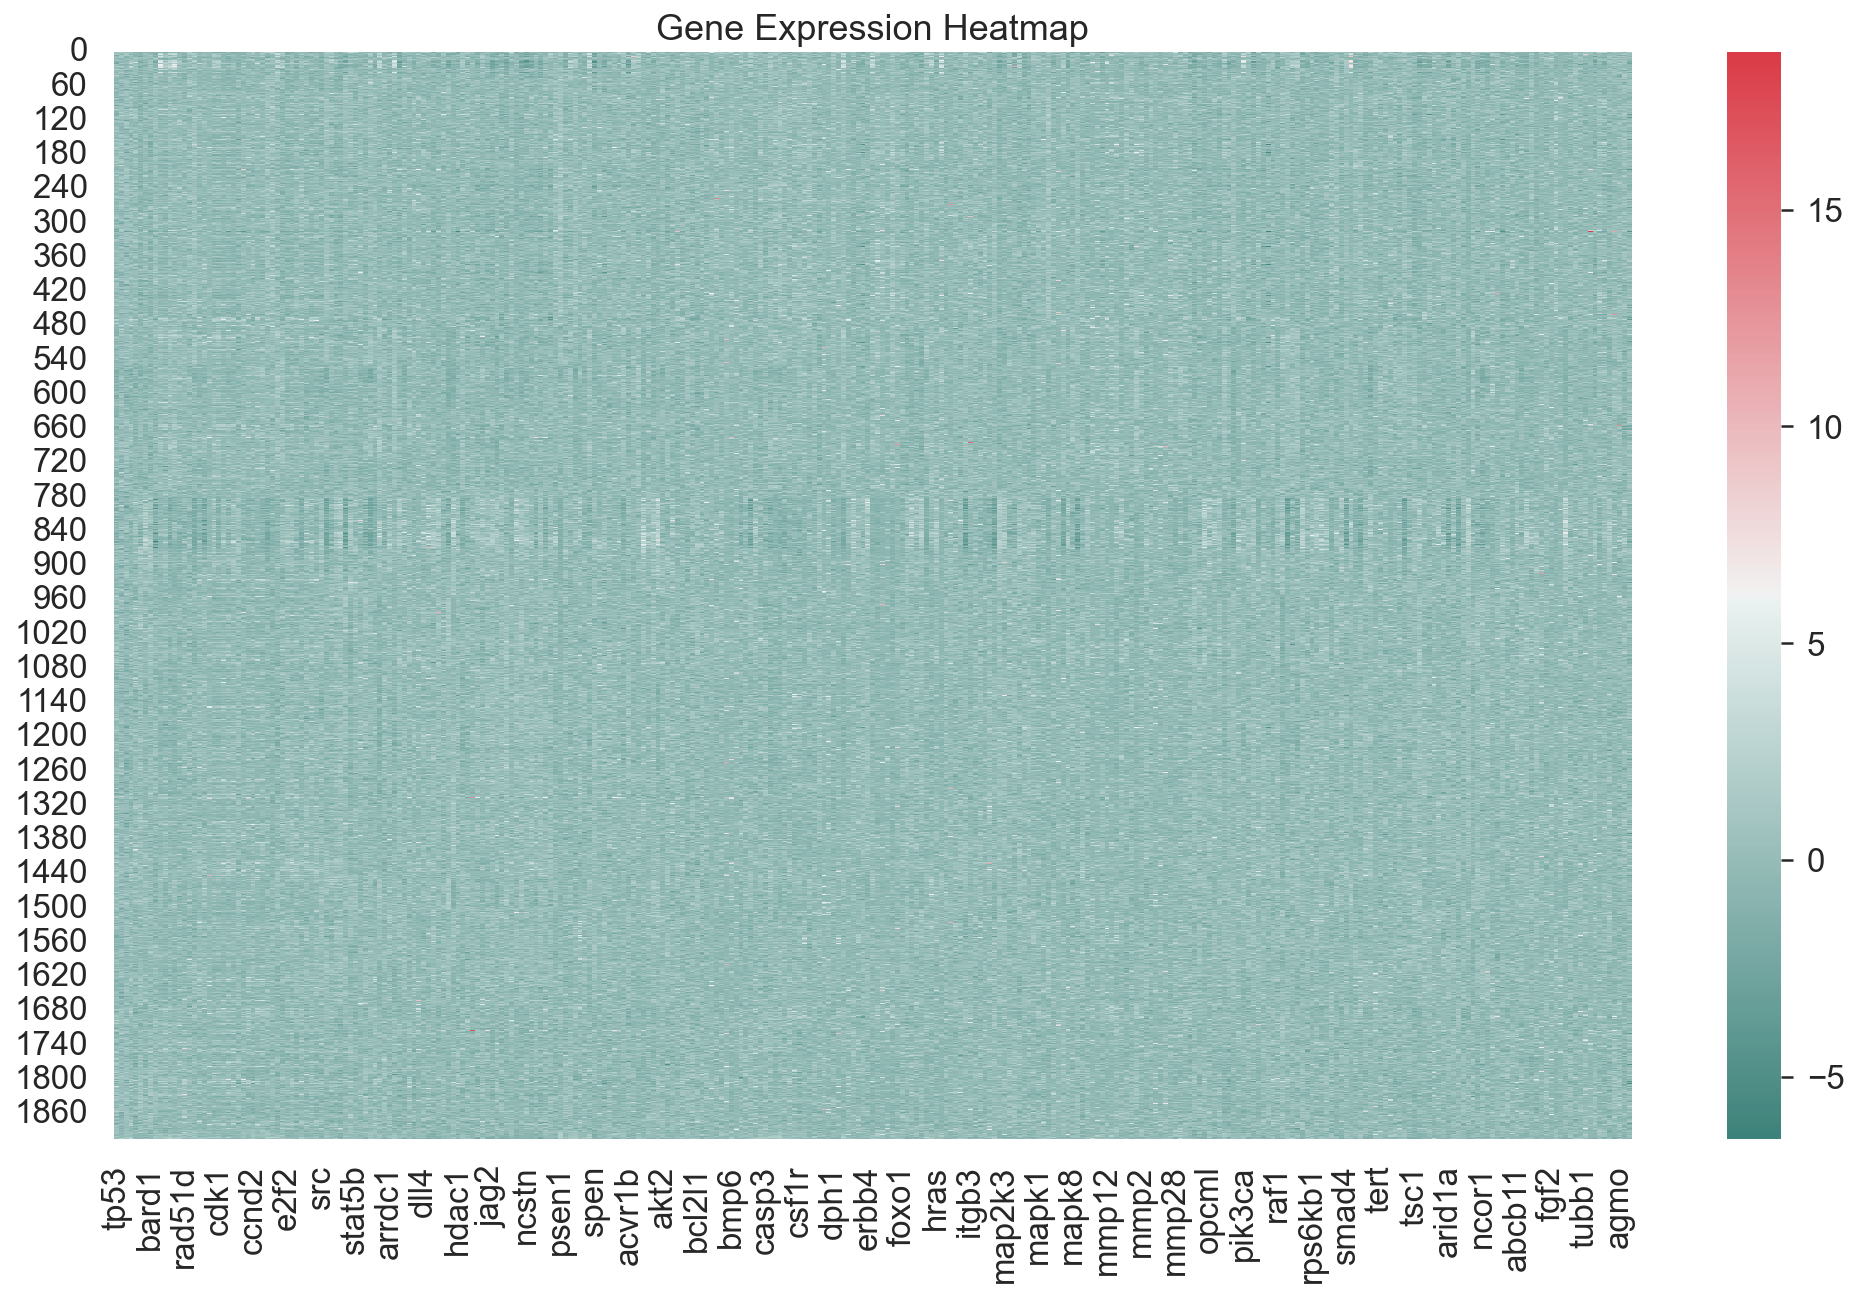

In [84]:
# Visualizing the mRNA values in a heatmap.
fig, axs = plt.subplots(figsize = (17, 10)) 
sns.heatmap(genetic_df.drop(['patient_id','overall_survival'], axis=1), ax = axs, cmap = sns.diverging_palette(180, 10, as_cmap = True))
plt.title('Gene Expression Heatmap')

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

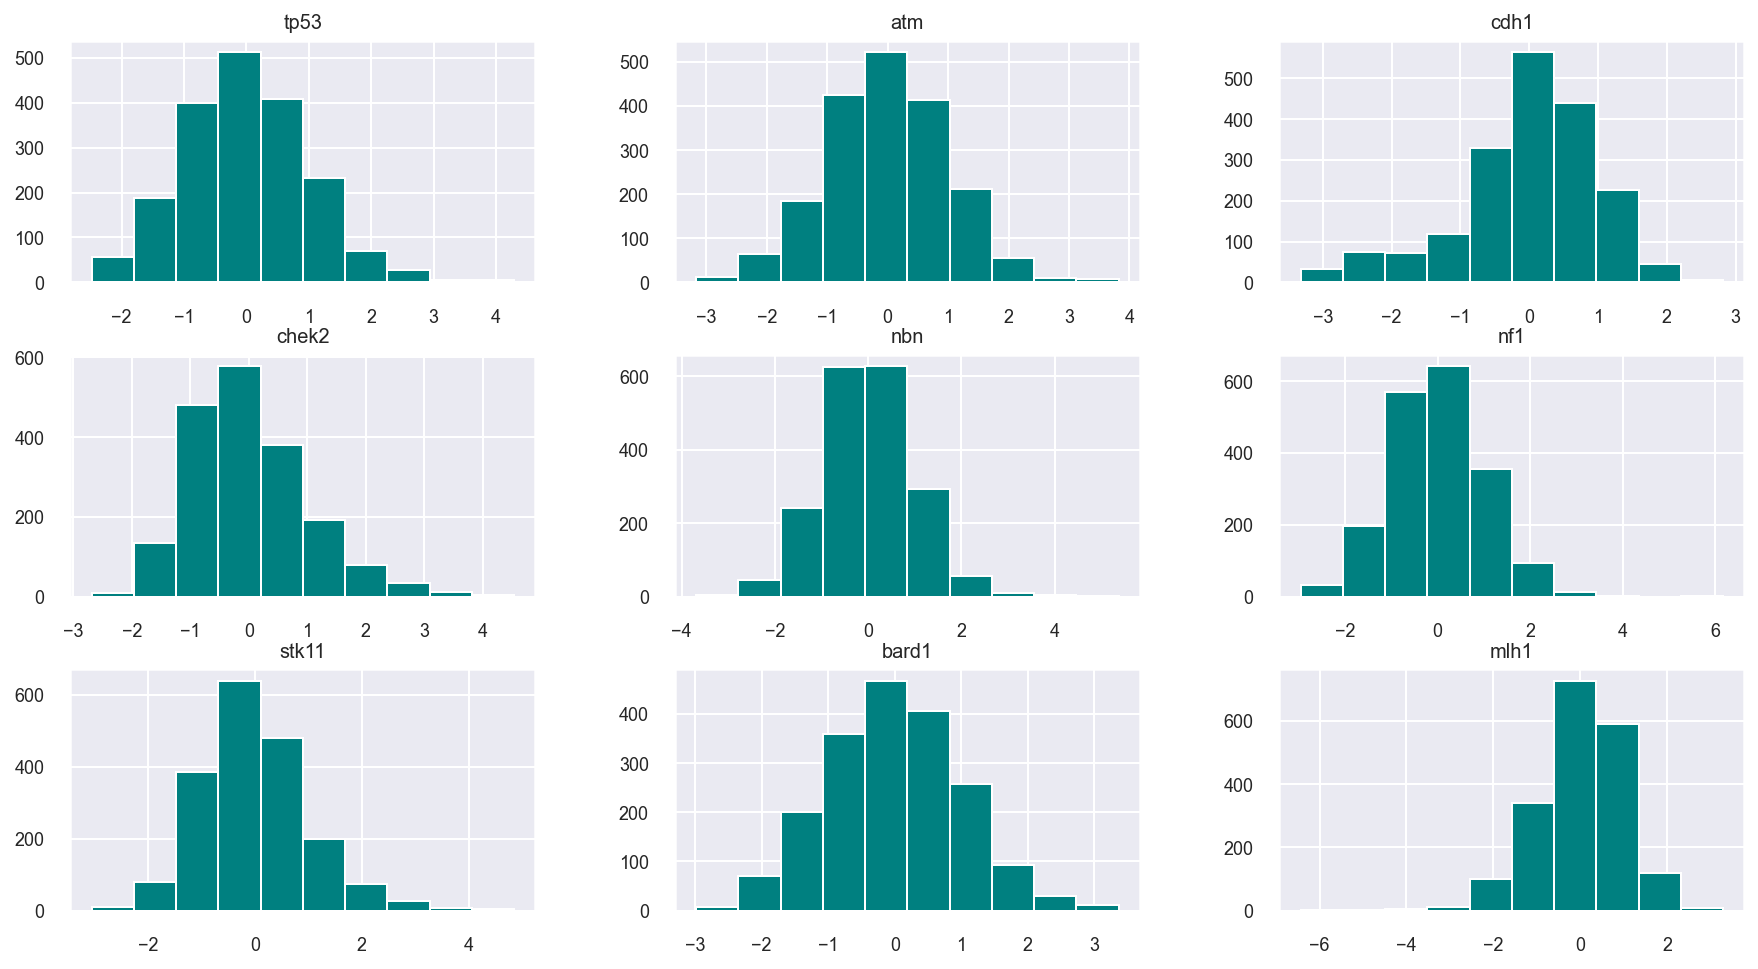

In [85]:
params = {'axes.titlesize':'10',
          'xtick.labelsize':'9',
          'ytick.labelsize':'9'}
matplotlib.rcParams.update(params)
#plt.subplots_adjust(hspace=0.5) 
genetic_df.drop(['patient_id','overall_survival'], axis=1).iloc[:,:9].hist(figsize=(15,8), color=color_hist)
plt.show()

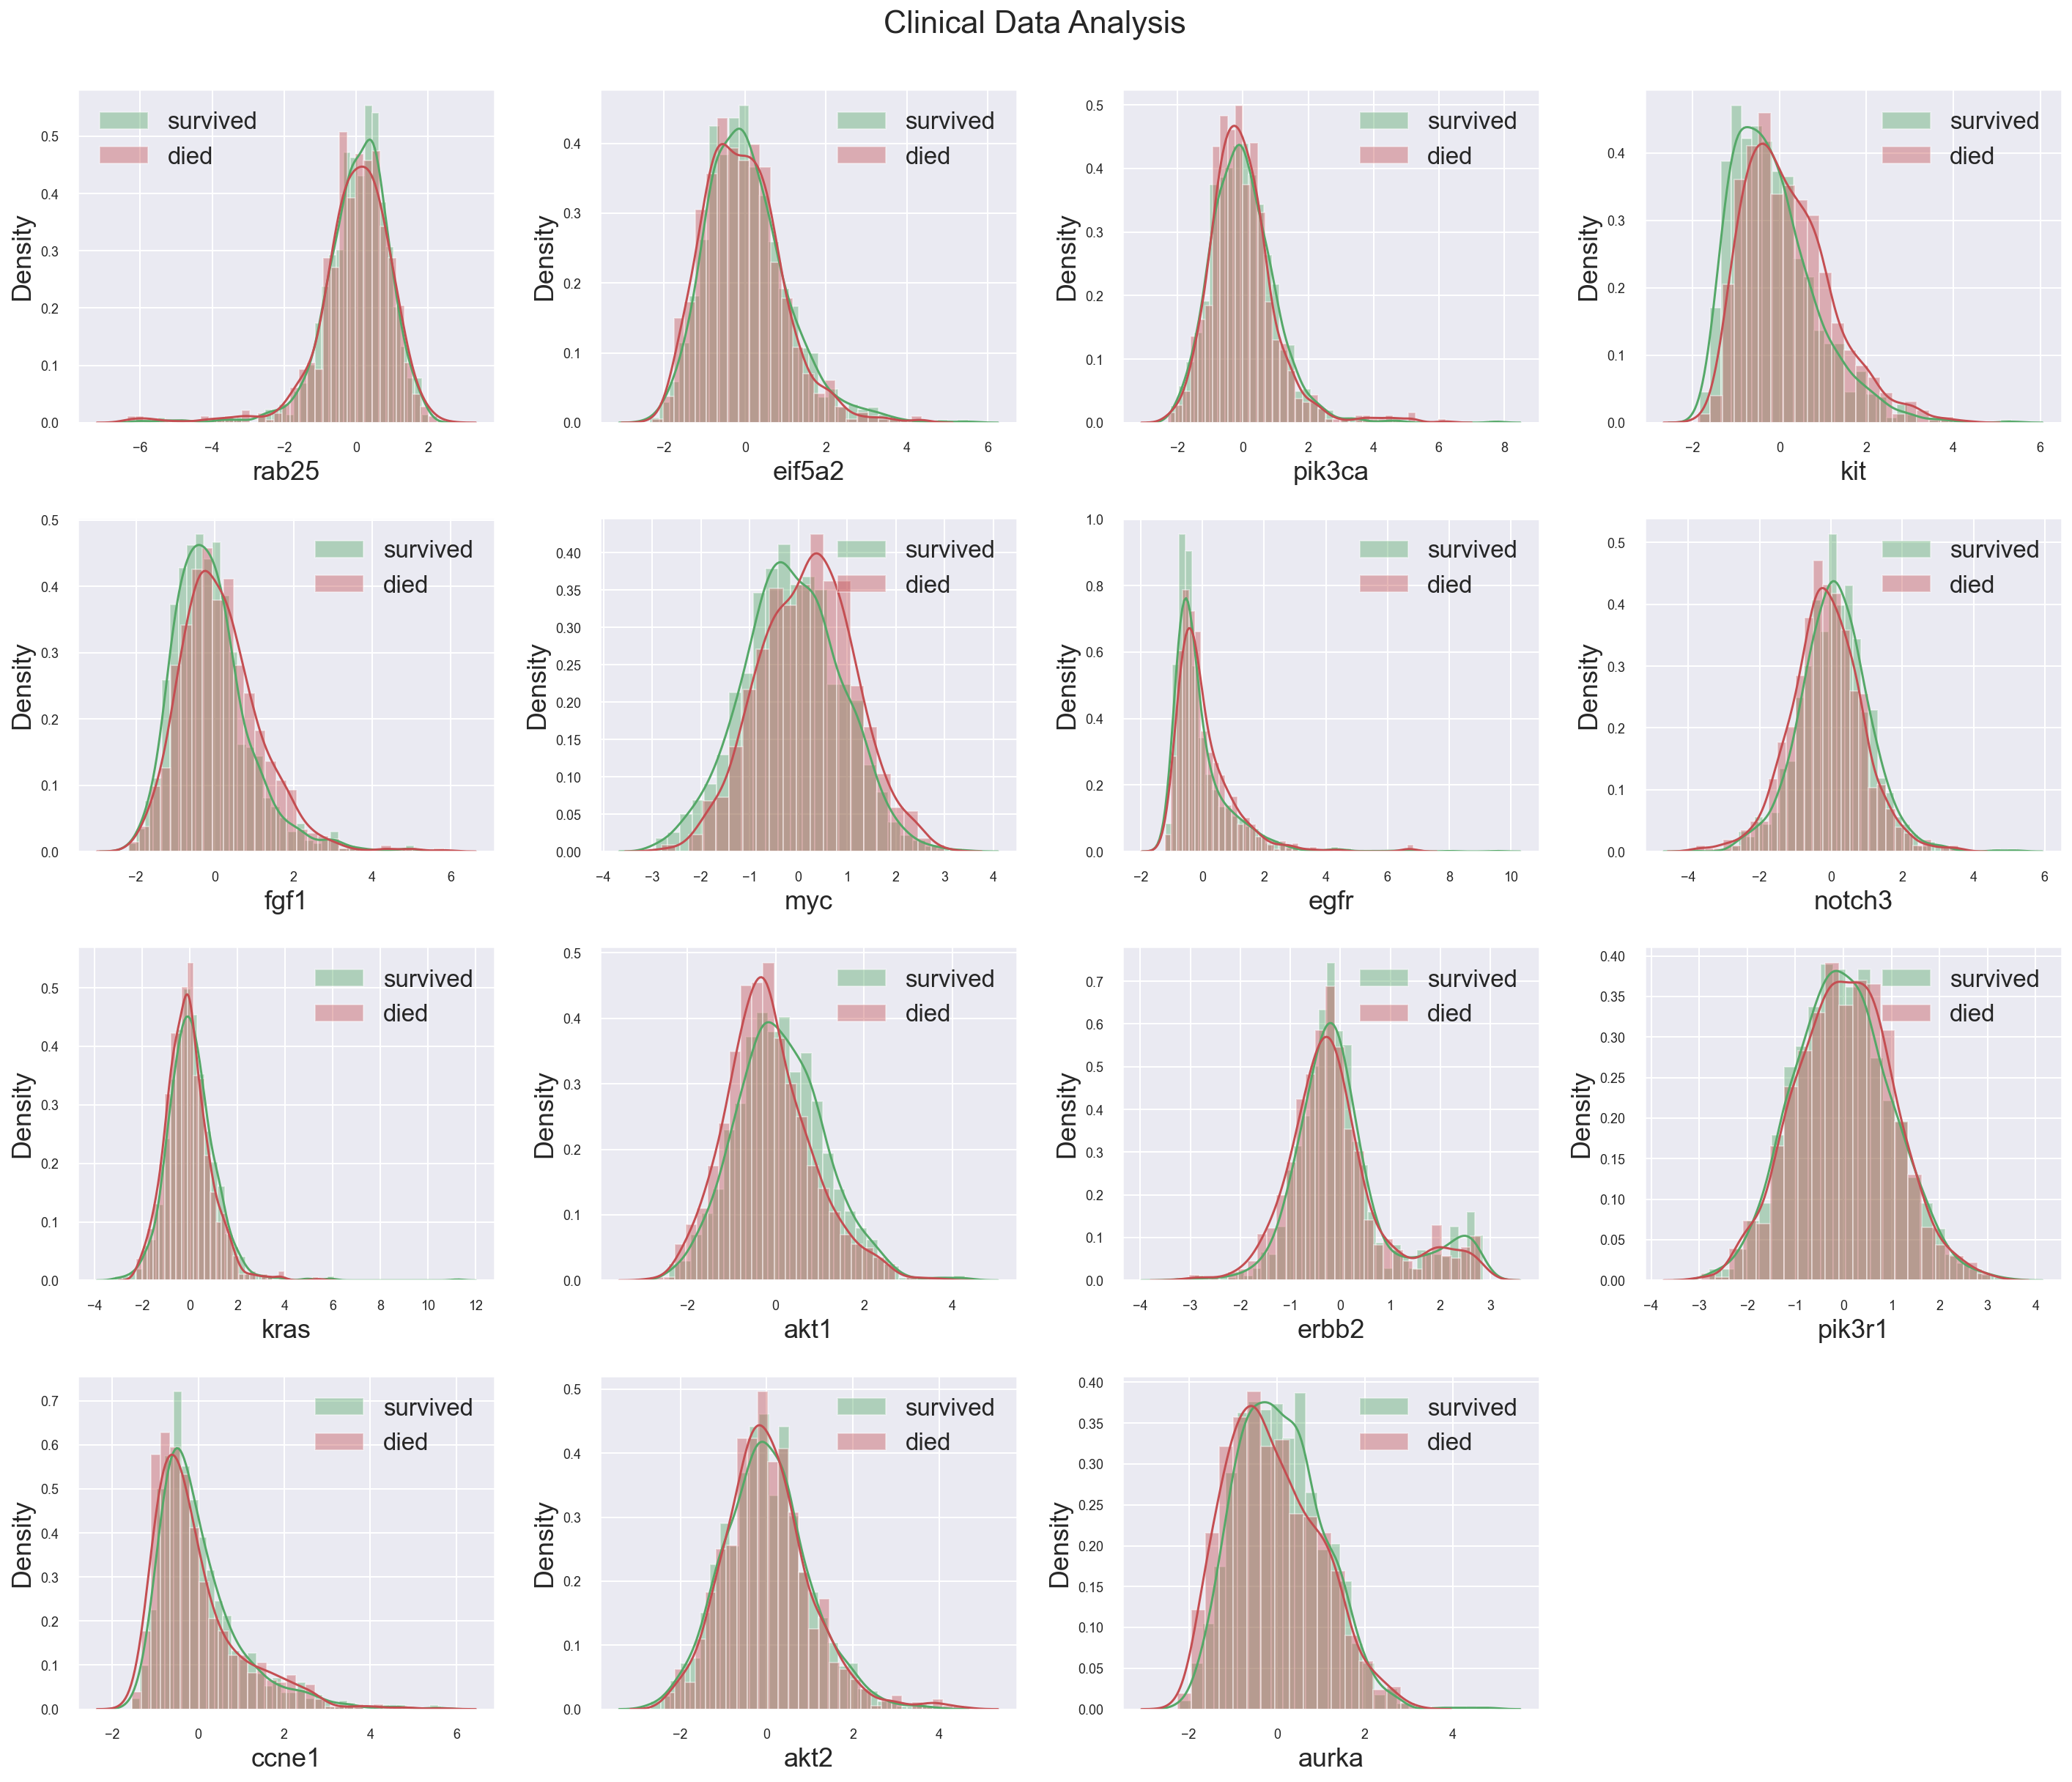

In [86]:
fig = plt.figure(figsize = (20, 25))
j = 0

gene_list = ['rab25', 'eif5a2', 'pik3ca', 'kit', 'fgf1', 'myc', 'egfr', 'notch3', 'kras', 'akt1', 'erbb2', 'pik3r1', 'ccne1', 'akt2', 'aurka']
for i in genetic_df.drop(['patient_id'], axis=1).loc[:,gene_list].columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(genetic_df[i][genetic_df['overall_survival']==0], color='g', label = 'survived')
    sns.distplot(genetic_df[i][genetic_df['overall_survival']==1], color='r', label = 'died')
    plt.legend(loc='best')
fig.suptitle('Clinical Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()


The distribution of data in the two classes of survival are very similar with few outliers in some genes. 

In [87]:
print('Maximum value possible in genetic data:', genetic_df.drop(['patient_id','overall_survival'], axis = 1).max().max())
print('Minimum value possible in genetic data:', genetic_df.drop(['patient_id','overall_survival'], axis = 1).min().min())

Maximum value possible in genetic data: 18.6351
Minimum value possible in genetic data: -6.4387


- #### Number of outliers in the top 10 genetic features

In [88]:
#Finding number of outliers in each column
Q1 = genetic_df.quantile(0.25)
Q3 = genetic_df.quantile(0.75)
IQR = Q3 - Q1
((genetic_df < (Q1 - 1.5 * IQR)) | (genetic_df > (Q3 + 1.5 * IQR))).sum().sort_values(ascending = False).head(10)

erbb2     224
dll3      194
mmp1      186
mmp12     180
cdkn2a    179
ccna1     154
bmp7      152
wwox      148
map2      144
folr1     142
dtype: int64

- #### Visualize Correlation of between the genetic Attributes and outcome

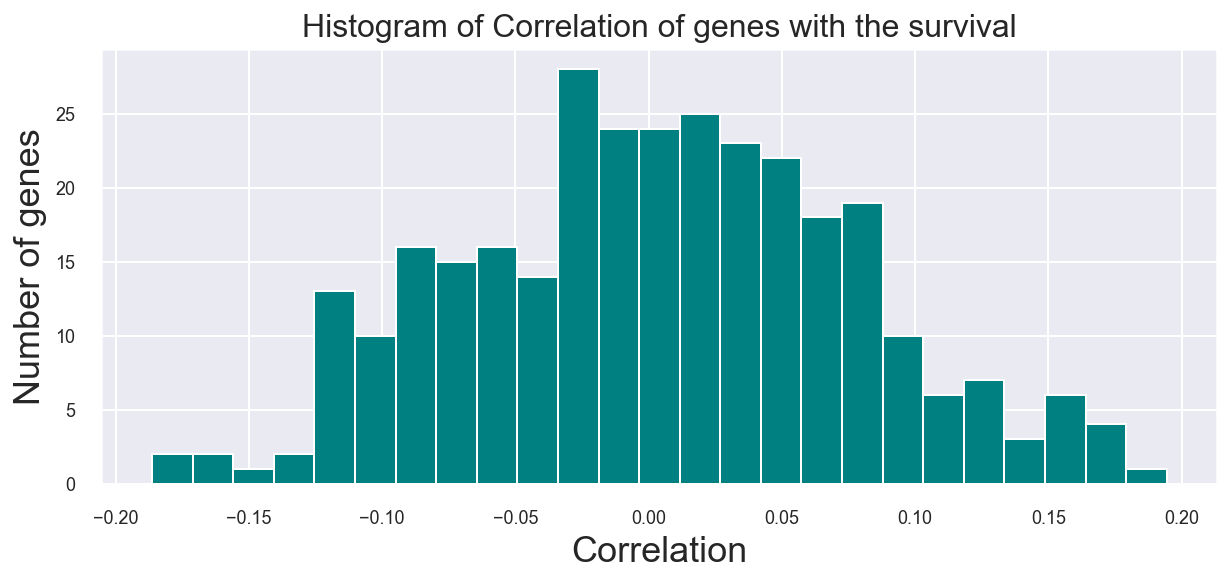

In [89]:
#how varied are genes and how well do they correlate with eventdeath?
fig, ax = plt.subplots(figsize=(10,4))

#plot histogram of variation using standard deviation as a measure
corrs=[]
for col in genetic_df.drop(['patient_id'], axis = 1).columns:
    corr = genetic_df[[col,'overall_survival']].corr()['overall_survival'][col]
    corrs.append(corr)

corrs.pop(-1)
ax.hist(corrs,  bins=25, color = color_hist)
ax.set_xlabel("Correlation")
ax.set_ylabel("Number of genes")
ax.set_title("Histogram of Correlation of genes with the survival", size=16)


plt.show()

In [90]:
print("Maximum Correlation: " + "%.3f" %max(corrs))
print("Minimum Correlation: " + "%.3f" %min(corrs))
print("Mean Correlation: " + "%.3f" %np.mean(corrs))

Maximum Correlation: 0.194
Minimum Correlation: -0.186
Mean Correlation: 0.004


The correlation between our target and the genetic features shows that most features do not actually correlate.

<a name="mutation"></a>
### c) Relationship between genetic mutation attributes and outcomes

In [91]:
# droping clinical and genetic data
mutation_features_to_drop = df.columns[4:520]
mutation_df = df.drop(mutation_features_to_drop,axis=1)
mutation_df = mutation_df.drop(['age_at_diagnosis','type_of_breast_surgery','cancer_type'],axis=1)

# if there is a mutation=1, no-mutation=0
for column in mutation_df.columns[1:]:
    mutation_df[column]=pd.to_numeric(mutation_df[column], errors='coerce').fillna(1).astype(int)

mutation_df.insert(loc=1 , column='overall_survival', value=df['overall_survival'])

mutation_df.head()

patient_id  overall_survival  pik3ca_mut  tp53_mut  muc16_mut  ahnak2_mut  \
0           0                 1           0         0          0           0   
1           2                 1           0         1          0           0   
2           5                 0           1         0          0           0   
3           6                 1           1         0          0           0   
4           8                 0           0         1          0           0   

   kmt2c_mut  syne1_mut  gata3_mut  map3k1_mut  ...  mtap_mut  ppp2cb_mut  \
0          0          0          0           0  ...         0           0   
1          0          0          0           0  ...         0           0   
2          0          0          0           0  ...         0           0   
3          0          0          0           0  ...         0           0   
4          0          0          0           0  ...         0           0   

   smarcd1_mut  nras_mut  ndfip1_mut  hras_mut  prps2_mut  smarcb1_mut  \
0            0         0           0         0          0            0   
1            0         0           0         0          0            0   
2            0         0           0         0          0            0   
3            0         0           0         0          0            0   
4            0         0           0         0          0            0   

   stmn2_mut  siah1_mut  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0  

[5 rows x 175 columns]

Some genes had much more mutations than other genes. For example: PIK3CA (coding mutations in 40.1% of the samples) and TP53 (35.4%) dominated the mutation landscape. Only five other genes harboured coding mutations in at least 10% of the samples: MUC16 (16.8%); AHNAK2 (16.2%); SYNE1 (12.0%); KMT2C (also known as MLL3; 11.4%) and GATA3 (11.1%).

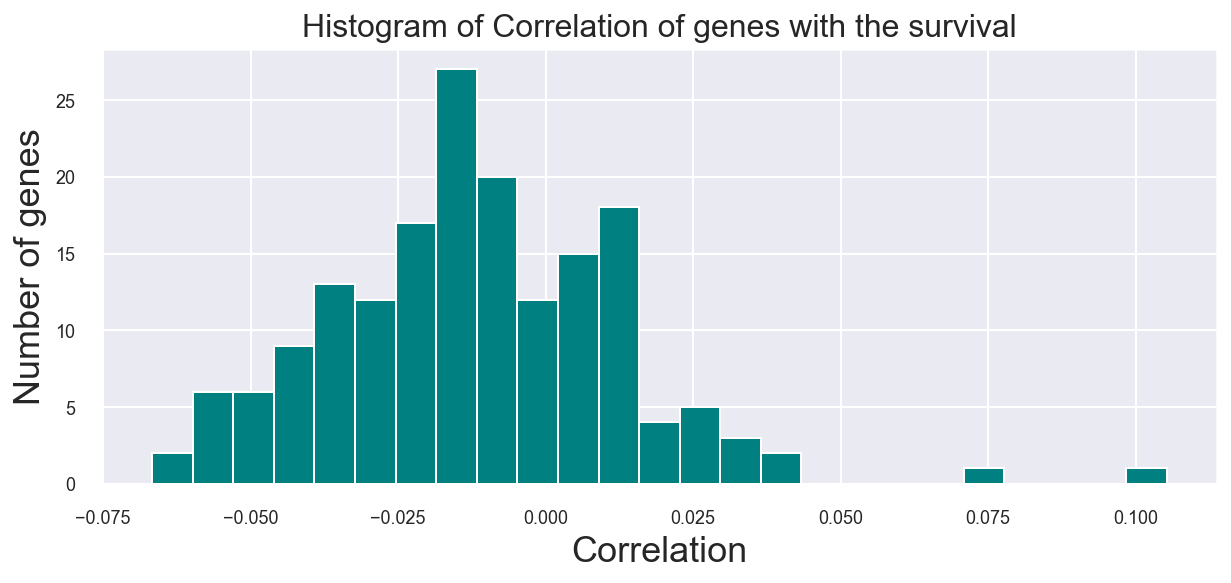

In [92]:
#plot histogram of variation using standard deviation as a measure
fig, ax = plt.subplots(figsize=(10,4))
corrs=[]
for col in mutation_df.drop(['patient_id'], axis = 1).columns:
    corr = mutation_df[[col,'overall_survival']].corr()['overall_survival'][col]
    corrs.append(corr)
    
corrs.pop(0)
ax.hist(corrs,  bins=25, color = color_hist)
ax.set_xlabel("Correlation")
ax.set_ylabel("Number of genes")
ax.set_title("Histogram of Correlation of genes with the survival", size=16)


plt.show()

In [93]:
print("Maximum Correlation: " + "%.3f" %max(corrs))
print("Minimum Correlation: " + "%.3f" %min(corrs))
print("Mean Correlation: " + "%.3f" %np.mean(corrs))

Maximum Correlation: 0.105
Minimum Correlation: -0.067
Mean Correlation: -0.012


No correlation at all between survival and mutations, as we changed the mutation to 0s and 1s instead of 0s if there is no mutations and the kind of mutation if there is a mutation. We decided to exclude the mutations from the mdeoling part for now, and maybe include it later when we analyse them in more detail. 

<a name="Preprocessing_and_Modeling"></a>
## Preprocessing and Modeling


In [94]:
BOLD = '\033[1m'
END = '\033[0m'
# using a stratfied k fold because we need the distribution of the to classes in all of the folds to be the same.
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [95]:
print('Baseline accuracy:' )
print(df["overall_survival"].value_counts()/df["overall_survival"].count())

Baseline accuracy:
0    0.579307
1    0.420693
Name: overall_survival, dtype: float64


 ### a) Classification with only clinical attributes

In [96]:
categorical_columns = clinical_df.select_dtypes(include=['object']).columns.tolist()
unwanted_columns = ['patient_id','death_from_cancer' ]
categorical_columns = [ele for ele in categorical_columns if ele not in unwanted_columns] 
# Getting dummies for all categorical columns
dummies_clinical_df = pd.get_dummies(clinical_df.drop('patient_id',axis=1 ), columns= categorical_columns, dummy_na=True)
dummies_clinical_df.dropna(inplace = True)

In [97]:
# data splitting
X = dummies_clinical_df.drop(['death_from_cancer', 'overall_survival'], axis=1)
y = dummies_clinical_df['overall_survival']
# using stratify for y because we need the distribution of the two classes to be equal in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

### Some helpful functions:

In [98]:
def model_metrics(model, kfold, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)

    #metrics
    results = cross_val_score(model, X_train, y_train, cv = kfold)
    print("CV scores: ", results); print("CV Standard Deviation: ", results.std()); print();
    print('CV Mean score: ', results.mean()); 
    print('Train score:   ', model.score(X_train, y_train))
    print('Test score:    ', model.score(X_test, y_test))
    
    pred = model.predict(X_test)
    # CODE HERE PLEASE
    print()
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, pred))
    print('Classification Report:  ')
    print(classification_report(y_test, pred))
    train_score =  model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    test_pred = model.predict(X_test)
    return test_pred, test_score, results.mean()

def basic_classifiers (X_train, X_test, y_train, y_test, kfold):
    BOLD = '\033[1m'
    END = '\033[0m'
    
    # Scaling 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    ######################################################################################################  K Neighbors Classifier model
    
    params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    print(); print(BOLD + 'K Neighbors Classifier Model:' + END)
    knn= GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, cv=4)
    knn_pred, knn_test, knn_train = model_metrics(knn, kfold, X_train, X_test, y_train, y_test)
    
    ###################################################################################################### Logistic Regression
    params = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-2,4,100)
    }
    print(); print(BOLD + 'Logistic Regression Model:' + END)
    logistic_regression = GridSearchCV(LogisticRegression(random_state=42), params, n_jobs=-1, cv=4)
    lg_pred, lg_test, lg_train = model_metrics(logistic_regression, kfold, X_train, X_test, y_train, y_test)
    
    ###################################################################################################### Decision Tree
    
    print(); print(BOLD + 'Decision Tree Classifier Model:' + END)
    decision_tree = DecisionTreeClassifier(random_state=42)
    dt_pred, dt_test, dt_train = model_metrics(decision_tree, kfold, X_train, X_test, y_train, y_test)
    
    ###################################################################################################### Random Forest Classifier
    
    print(); print(BOLD + 'Random Forest Classifier Model:' + END)
    random_forest = RandomForestClassifier(random_state=42)
    rf_pred, rf_test, rf_train = model_metrics(random_forest, kfold, X_train, X_test, y_train, y_test)
    
    ###################################################################################################### Extra Trees Classifier
   
    print(); print(BOLD + 'Extra Trees Classifier Model:' + END)
    extra_trees = ExtraTreesClassifier(random_state=42)
    et_pred, et_test, et_train = model_metrics(extra_trees, kfold, X_train, X_test, y_train, y_test)
    
    ###################################################################################################### AdaBoost Classifier
    
    print(); print(BOLD + 'AdaBoost Classifier Model:' + END)
    ada_boost = AdaBoostClassifier(random_state=42)
    ab_pred, ab_test, ab_train = model_metrics(ada_boost, kfold, X_train, X_test, y_train, y_test)
    
    ###################################################################################################### SVC Classifier
    
    print(); print(BOLD + 'SVC Classifier Model:' + END)
    svc = SVC(random_state=42)
    svc_pred, svc_test, svc_train = model_metrics(svc, kfold, X_train, X_test, y_train, y_test)

    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

    
    #bar chart of accuracy scores
    inds = range(1,8)
    labels = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest",'Extra Trees', 'AdaBoost', 'SVC' ]
    scores_all = [knn_train, lg_train, dt_train, rf_train, et_train, ab_train, svc_train]
    scores_predictive = [knn_test, lg_test, dt_test, rf_test, et_test, ab_test, svc_test]
    
    ax1.bar(inds, scores_all, color=sns.color_palette(color)[5], alpha=0.3, hatch="x", edgecolor="none",label="CrossValidation Set")
    ax1.bar(inds, scores_predictive, color=sns.color_palette(color)[0], label="Testing set")
    ax1.set_ylim(0.4, 1)
    ax1.set_ylabel("Accuracy score")
    ax1.axhline(0.5793, color="black", linestyle="--")
    ax1.set_title("Accuracy scores for basic models", fontsize=17)
    ax1.set_xticks(range(1,8))
    ax1.set_xticklabels(labels, size=12, rotation=40, ha="right")
    ax1.legend()

    labels = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest",'Extra Trees', 'AdaBoost', 'SVC' ]
    for label, pred in zip(labels, [knn_pred, lg_pred, dt_pred, rf_pred, et_pred, ab_pred, svc_pred]):
        fpr, tpr, threshold = roc_curve(y_test.values, pred)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=2)
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax2.set_xlim([-0.05, 1.0])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc="lower right", prop={'size': 12})
    ax2.set_title("Roc curve for for basic models", fontsize=17)

    plt.show()
    
    
# a function that takes a dataframe and plots histograms for all columns 
def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels, big_title_name):
    
    nrows = int(np.ceil(len(list_of_columns)/3)) # Makes sure you have enough rows
    fig, ax = plt.subplots(ncols=3,nrows=nrows, figsize=(15, 10)) # You'll want to specify your figsize
    fig.suptitle(big_title_name, fontsize=15)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column].dropna(), color= color_hist ) # feel free to add more settings
        #ax[i].set_xlabel(list_of_xlabels[i])
        ax[i].set_ylabel('Frequency')
        ax[i].set_title(list_of_titles[i]) # Set titles, labels, etc here for each subplot    
    plt.show()
    
    
# a function that takes a dataframe and plots barplot for all columns 
def subplot_bargraph(dataframe, list_of_columns, list_of_titles, list_of_xlabels, big_title_name):
    
    nrows = int(np.ceil(len(list_of_columns)/3)) # Makes sure you have enough rows
    fig, ax = plt.subplots(ncols=3,nrows=nrows, figsize=(15, 10)) # You'll want to specify your figsize
    fig.suptitle(big_title_name, fontsize=20)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.countplot(dataframe[column].dropna(), color= color_hist, ax=ax[i], hue=dataframe['eventdeath']) # feel free to add more settings
        #ax[i].set_xlabel(list_of_xlabels[i])
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Frequency')
        ax[i].set_title(list_of_titles[i]) # Set titles, labels, etc here for each subplot    
    plt.show()        


K Neighbors Classifier Model:
CV scores:  [0.69886364 0.6875     0.68       0.64       0.67428571]
CV Standard Deviation:  0.019848679109833157

CV Mean score:  0.6761298701298701
Train score:    1.0
Test score:     0.6458333333333334

Confusion Matrix: 
[[203  42]
 [111  76]]
Classification Report:  
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       245
           1       0.64      0.41      0.50       187

    accuracy                           0.65       432
   macro avg       0.65      0.62      0.61       432
weighted avg       0.65      0.65      0.63       432


Logistic Regression Model:
CV scores:  [0.71590909 0.71590909 0.74857143 0.70285714 0.76571429]
CV Standard Deviation:  0.023469275264273868

CV Mean score:  0.7297922077922078
Train score:    0.7753705815279361
Test score:     0.7777777777777778

Confusion Matrix: 
[[201  44]
 [ 52 135]]
Classification Report:  
              precision    recall  f1-score   support

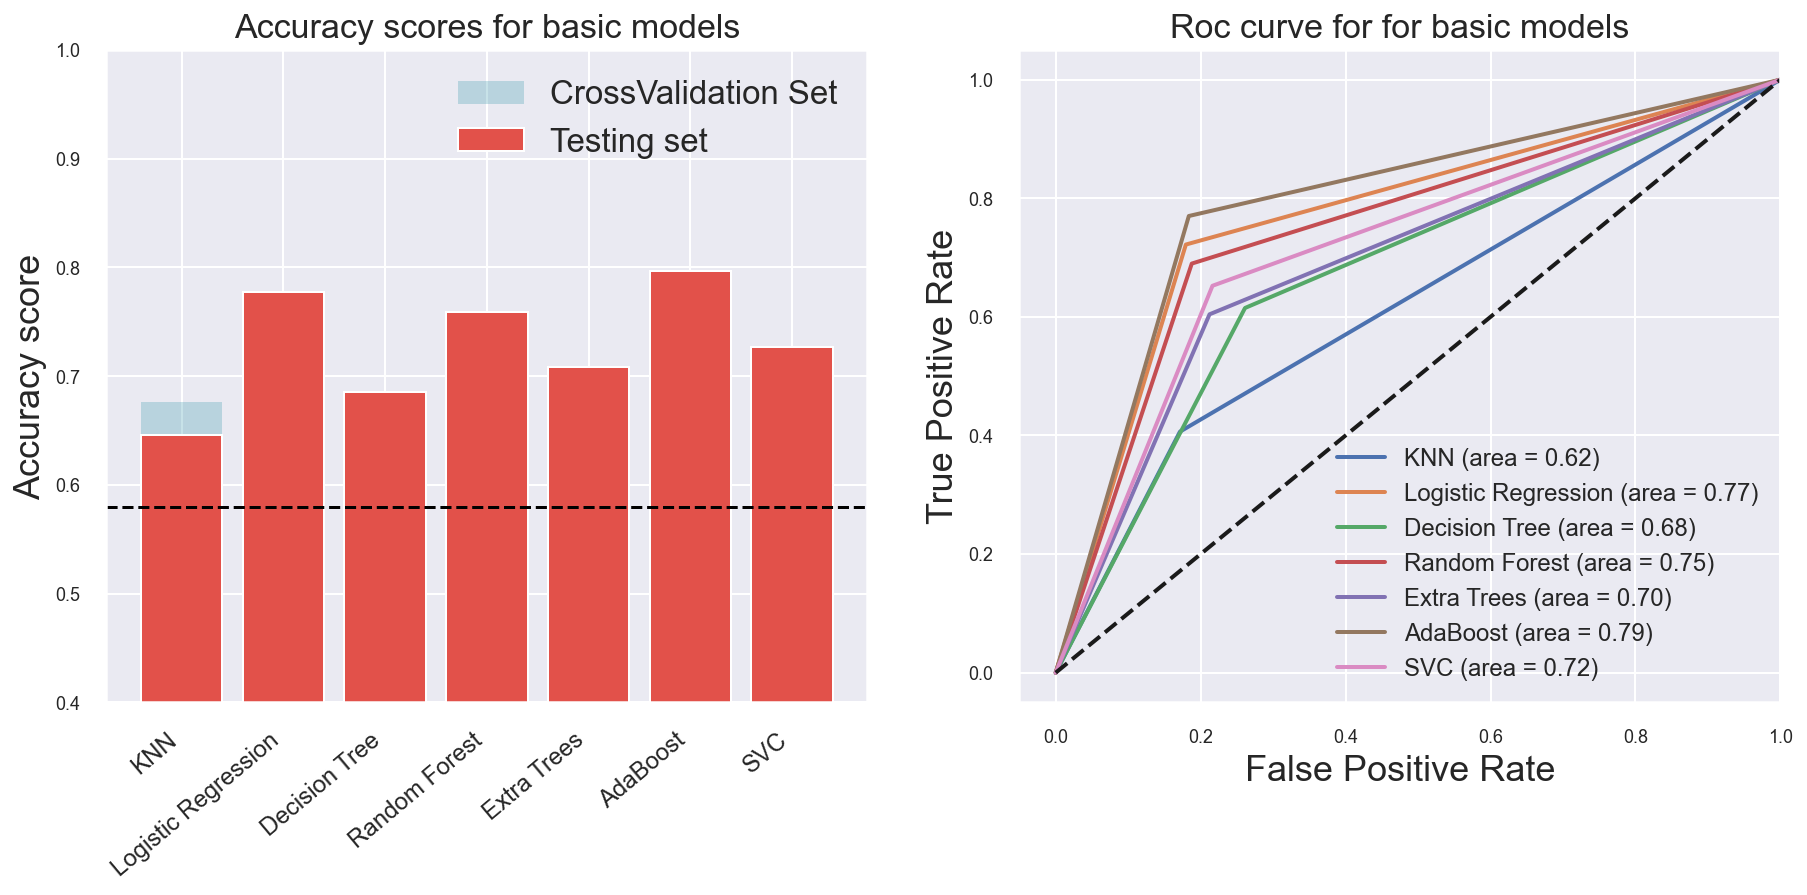

In [99]:
basic_classifiers( X_train, X_test, y_train, y_test, kfold)

Logistic regression model preformed the best with accuracy of 0.777 and AUC of 0.777, KNN having the lowest accuracy of 0.64, and AUC of 0.62

- ### XGBoost: Final try to increase the predictive score

After tuning the hyperparamenters, these are the final parameters:
- max_depth: 5
- min_child_weight: 3, 1
- gamma: 0

In [62]:
def model_visualization (labels, scores_all, scores_predictive, pred, title, inds, y_test_sets):
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(13,6))

    fig.suptitle(title, fontsize=16)
    #bar chart of accuracy scores

    ax1.bar(inds, scores_all, color=sns.color_palette(color)[5], alpha=0.3, hatch="x", edgecolor="none",label="CrossValidation Set") #
    ax1.bar(inds, scores_predictive, color=sns.color_palette(color)[0], label="Testing set")
    ax1.set_ylim(0.4, 1)
    ax1.set_ylabel("Accuracy score")
    ax1.axhline(0.5793, color="black", linestyle="--")
    ax1.axhline(0.7758346581875993, color="red", linestyle="--")
    ax1.set_title("Accuracy scores", fontsize=17)
    ax1.set_xticks(inds)
    ax1.set_xticklabels(labels, size=14)
    ax1.legend()
    


    for label, pred, y_test in zip(labels, pred, y_test_sets):
        fpr, tpr, threshold = roc_curve(y_test.values, pred)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=2)
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax2.set_xlim([-0.05, 1.0])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc="lower right", prop={'size': 14})
    ax2.set_title("Roc curve", fontsize=17)

    plt.show()

- ### XGBoost for clinical features:

In [63]:
categorical_columns = clinical_df.select_dtypes(include=['object']).columns.tolist()
unwanted_columns = ['patient_id','death_from_cancer' ]
categorical_columns = [ele for ele in categorical_columns if ele not in unwanted_columns] 
dummies_clinical_df = pd.get_dummies(clinical_df.drop('patient_id',axis=1 ), columns= categorical_columns, dummy_na=True)

# data splitting
X = dummies_clinical_df.drop(['death_from_cancer', 'overall_survival'], axis=1)
y = dummies_clinical_df['overall_survival']

X_train, X_test, y_train, y_test_c = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [64]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

clinical_xgb1_pred_, clinical_xgb1_test_score, clinical_xgb1_cv_score = model_metrics(xgb1, kfold, X_train, X_test, y_train, y_test_c)

CV scores:  [0.76862745 0.75686275 0.81568627 0.74509804 0.70980392]
CV Standard Deviation:  0.03442056197253598

CV Mean score:  0.7592156862745097
Train score:    1.0
Test score:     0.7710651828298887

Confusion Matrix: 
[[299  65]
 [ 79 186]]
Classification Report:  
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       364
           1       0.74      0.70      0.72       265

    accuracy                           0.77       629
   macro avg       0.77      0.76      0.76       629
weighted avg       0.77      0.77      0.77       629



XGBoost preformed very well combared to traditional basic models, and the best model was the one that was trained with all of the features combined with accuracy of 0.779 and AUC of 0.76

<a name="Deploy"></a>
## Deploy



In [ ]:
#Save trained model
xgb1.save_model("model.json")

#Load model
xgb2 = XGBClassifier()
xgb2.load_model("model.json")

#Define function for web demo
def survive (i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, i14, i15, i16, i17, i18, i19, i20, i21, i22, i23, i24, i25, i26, i27):
    to_predict = pd.DataFrame({'age_at_diagnosis': [i1],
                                'type_of_breast_surgery': [i2],
                                'cancer_type': [i3],
                                'cancer_type_detailed': [i4],
                                'cellularity': [i5],
                                'chemotherapy': [i6],
                                'pam50_+_claudin-low_subtype': [i7],
                                'cohort': [i8],
                                'er_status_measured_by_ihc': [i9],
                                'er_status': [i10],
                                'neoplasm_histologic_grade': [i11],
                                'her2_status_measured_by_snp6': [i12],
                                'her2_status': [i13],
                                'tumor_other_histologic_subtype': [i14],
                                'hormone_therapy': [i15],
                                'inferred_menopausal_state': [i16],
                                'integrative_cluster': [i17],
                                'primary_tumor_laterality': [i18],
                                'lymph_nodes_examined_positive': [i19],
                                'mutation_count': [i20],
                                'nottingham_prognostic_index': [i21],
                                'oncotree_code': [i22],
                                'pr_status': [i23],
                                'radio_therapy': [i24],
                                '3-gene_classifier_subtype': [i25],
                                'tumor_size': [i26],
                                'tumor_stage': [i27]})
    to_predict_dummies = pd.get_dummies(to_predict, columns= categorical_columns, dummy_na=True)
    dummy = to_predict_dummies
    misscols = list(set(X_train.columns) - set(dummy.columns))
    for col in misscols:
        dummy[col] = 0
    dummy = dummy[X_train.columns]
    all_columns = list(dummy) # Creates list of all column headers
    dummy[all_columns] = dummy[all_columns].astype(float)
    all_columns = list(dummy) # Creates list of all column headers
    dummy[all_columns] = dummy[all_columns].astype(int)
    final = xgb2.predict_proba(dummy)
    live = final[:, [1]]
    return "Your surviving rate after the surgery is: " "%.7f%%" % (100 * live)

#Web deploy with Gradio
import gradio as gr
with gr.Blocks() as demo:

    gr.Markdown(
    """
    ## Breast Cancer surgery survival rate prediction 🚑
    This model will predict the survival rate of patient after taking Breast Cancer surgery with an accuracy rate of 78 percent and is extremely fast.
    """)
    gr.Markdown(
    """
    The result will be shown here after you finished inputing:
    """)
    with gr.Row():
        out = outputs=gr.Textbox(label="Prediction result:")
    gr.Markdown(
    """
    ## INPUT
    Please fill in your clinical information below:
    """)
    with gr.Column():
        inp = [gr.Dropdown(["26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48", "49", "50", "51", "52", "53", "54", "55", "56", "57", "58", "59", "60", "61", "62", "63", "64", "65", "66", "67", "68", "69", "70", "71", "72", "73", "74", "75", "76", "77", "78", "79", "80", "81", "82", "83", "84", "85", "86", "87", "88", "89", "90", "92", "96"], label="Age"), 
                                    gr.Radio(["MASTECTOMY", "BREAST CONSERVING"], label="Type of breast surgery", type="index"),
                                    gr.Radio(["Breast Cancer", "Breast Sarcoma"], label="Cancer type", type="index"),
                                    gr.Dropdown(["Breast Invasive Ductal Carcinoma", "Breast Mixed Ductal and Lobular Carcinoma", "Breast Invasive Lobular Carcinoma", "Breast Invasive Mixed Mucinous Carcinoma", "Breast", "Metaplastic Breast Cancer" ], label="Detailed cancer type"),
                                    gr.Radio(["High", "Moderate", "Low"], label="Cellularity (The amount of tumor cells and their arrangement into clusters)", type="index"),
                                    gr.Radio(["0", "1"], label="Chemotherapy treatment (Yes = 1, No = 0)", type="index"),
                                    gr.Dropdown(["claudin-low", "LumA", "LumB", "Her2", "Normal", "Basal", "NC"], label="Pam 50 tumor profiling test result"),
                                    gr.Dropdown(["1", "2", "3", "4", "5"], label="Cohort"),
                                    gr.Radio(["Positve", "Negative"], label="Estrogen receptors status measured by ihc", type="index"),
                                    gr.Radio(["Positve", "Negative"], label="Estrogen receptors status", type="index"),
                                    gr.Radio(["1.0", "2.0", "3.0"], label="Neoplasm histologic grade", type="index"),
                                    gr.Radio(["NEUTRAL", "LOSS", "GAIN", "UNDEF"], label="HER2 status measured by snp6", type="index"),
                                    gr.Radio(["Positve", "Negative"], label="HER2 status", type="index"),
                                    gr.Dropdown(["Ductal/NST", "Mixed", "Lobular", "Tubular/ cribriform", "Mucinous", "Medullary", "Metaplastic", "Other"], label="Tumor other histologic subtype"),
                                    gr.Radio(["0", "1"], label="Hormone therapy treatment (Yes = 1, No = 0)", type="index"),
                                    gr.Radio(["Post", "Pre"], label="Inferred menopausal state", type="index"),
                                    gr.Dropdown(["1", "2", "3", "4ER+", "4ER-", "5", "6", "7", "8", "9", "10"], label="Integrative cluster"),
                                    gr.Radio(["Right", "Left"], label="Primary tumor laterality", type="index"),
                                    gr.Dropdown(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "31", "33", "41", "45"], label="Lymph nodes examined positive"),
                                    gr.Dropdown(["1.0", "2.0", "3.0", "4.0", "5.0", "6.0", "7.0", "8.0", "9.0", "10.0", "11.0", "12.0", "13.0", "14.0", "15.0", "16.0", "17.0", "18.0", "19.0", "20.0", "21.0", "22.0", "23.0", "24.0", "26.0", "28.0", "30.0", "40.0", "46.0", "80.0"], label="Mutation count"),
                                    gr.Dropdown(['1.0','1.02','1.022','1.024','1.028','1.03','1.032','1.034','1.036','1.04','1.042','1.048','1.05','1.054','1.06','1.07','1.076','1.12','2.0','2.002','2.014','2.018','2.02','2.022','2.024','2.026','2.0276','2.028','2.03','2.032','2.034','2.036','2.038','2.04','2.042','2.044','2.046','2.048','2.05','2.052','2.054','2.06','2.064','2.066','2.07','2.072','2.08','2.0806','2.086','2.092','2.094','2.096','2.1','2.114','2.124','2.198','3.0','3.002','3.00424','3.0046','3.006','3.01','3.012','3.016','3.018','3.02','3.022','3.0236','3.024','3.025','3.0252','3.026','3.028','3.03','3.031','3.0314','3.032','3.0338','3.034','3.036','3.038','3.04','3.042','3.0426','3.043','3.0432','3.044','3.046','3.048','3.05','3.0502','3.052','3.054','3.056','3.058','3.06','3.062','3.064','3.066','3.068','3.07','3.074','3.078','3.08','3.084','3.086','3.09','3.096','3.1','3.11','3.12','3.122','3.13','3.14','3.142','3.16','3.17','3.198','3.2','4.0','4.002','4.004','4.006','4.01','4.016','4.018','4.02','4.022','4.024','4.025','4.026','4.028','4.0286','4.029','4.03','4.0304','4.031','4.032','4.034','4.0354','4.0358','4.036','4.0366','4.038','4.04','4.042','4.043','4.044','4.045','4.046','4.048','4.0488','4.05','4.052','4.054','4.056','4.057','4.058','4.06','4.062','4.064','4.0652','4.066','4.068','4.07','4.072','4.074','4.076','4.078','4.08','4.082','4.084','4.086','4.088','4.09','4.092','4.094','4.096','4.098','4.1','4.102','4.11','4.114','4.12','4.124','4.13','4.136','4.14','4.15','4.158','4.2','5.0','5.002','5.004','5.01','5.011','5.012','5.02','5.022','5.024','5.0256','5.026','5.028','5.03','5.032','5.0324','5.034','5.0344','5.0352','5.036','5.037','5.038','5.04','5.041','5.042','5.044','5.04464','5.046','5.048','5.05','5.052','5.054','5.056','5.058','5.06','5.062','5.064','5.066','5.068','5.07','5.072','5.074','5.076','5.078','5.08','5.084','5.086','5.088','5.09','5.092','5.096','5.1','5.104','5.106','5.11','5.12','5.124','5.13','5.134','5.14','5.15','5.16','5.18','5.364','6.0','6.002','6.02','6.024','6.026','6.028','6.03','6.03094','6.032','6.034','6.036','6.038','6.04','6.042','6.044','6.046','6.048','6.0483','6.05','6.052','6.054','6.056','6.058','6.06','6.062','6.0622','6.064','6.068','6.07','6.072','6.074','6.076','6.08','6.084','6.086','6.088','6.09','6.094','6.096','6.1','6.102','6.104','6.106','6.11','6.12','6.13','6.15','6.16','6.168','6.198','6.2','6.24','6.26','6.3','6.32','6.36'], label="Nottingham prognostic index"),
                                    gr.Dropdown(["IDC", "MDLC", "ILC", "IMMC", "BREAST", "MBC"], label="Oncotree code"),
                                    gr.Radio(["Positve", "Negative"], label="Progesterone receptors status", type="index"),
                                    gr.Radio(["0", "1"], label="Radio therapy treatment (Yes = 1, No = 0)", type="index"),
                                    gr.Radio(["ER-/HER2-", "ER+/HER2- High Prolif", "ER+/HER2- Low Prolif", "HER2+"], label="Three Gene classifier subtype", type="index"),
                                    gr.Dropdown(['1.0', '10.0', '100.0', '11.0', '11.8', '12.0', '12.5', '12.6', '12.8', '120.0', '13.0', '13.8', '130.0', '14.0', '14.3', '14.5', '15.0', '15.2', '15.47', '15.5', '15.7', '150.0', '16.0', '16.2', '16.9', '160.0', '17.0', '17.2', '17.6', '17.7', '17.9', '18.0', '18.3', '18.5', '180.0', '182.0', '19.0', '2.0', '2.12', '2.3', '20.0', '20.5', '21.0', '21.3', '21.5', '21.6', '22.0', '22.32', '22.5', '23.0', '24.0', '24.15', '24.4', '25.0', '25.1', '26.0', '27.0', '28.0', '28.5', '29.0', '3.0', '30.0', '31.0', '31.1', '32.0', '32.6', '33.0', '34.0', '35.0', '36.0', '37.0', '38.0', '39.0', '40.0', '40.3', '41.0', '42.0', '43.0', '44.0', '45.0', '46.0', '47.0', '48.0', '49.0', '5.0', '5.5', '50.0', '51.0', '52.0', '53.0', '55.0', '57.0', '6.0', '60.0', '61.0', '62.0', '65.0', '67.0', '68.0', '7.0', '70.0', '71.0', '75.0', '79.0', '8.0', '80.0', '84.0', '85.0', '9.0', '90.0', '99.0'], label="Tumor size measured by imaging techniques"),
                                    gr.Radio(["0.0", "1.0", "2.0", "3.0" , "4.0"], label="Tumor stage", type="index")
                                    ]
    btn = gr.Button("Run")
    btn.click(fn=survive, inputs = inp, outputs = out) 

demo.launch(share=True)

<a name="Conclusions"></a>
## Conclusions

In conclusion, by offering accurate survival rate predictions and personalized insights, this Breast Cancer Surgery Survival Prediction web service aims to also support patients in making informed decisions about their treatment, reducing anxiety, and fostering trust with their healthcare providers. This innovative tool can help patients approach surgery with a more stable mindset, ultimately improving their overall experience and outcomes.


Link to the demo video presenting use cases and step-by-step usage of this Breast Cancer Surgery Survival Prediction:
https://youtu.be/NO7jPyVKsNs

